# Time Series Analysis

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import statsmodels.api as sm
import os

In [33]:
# Setting display options

# Pandas - Show more rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Seaborn
sns.set_style("darkgrid")
plt.matplotlib.style.use('default')

my_colors = ["windows blue", "saffron", "hot pink", "algae green", "dusty purple", "greyish", "petrol", "denim blue", "lime"]
sns.set_palette(sns.xkcd_palette(my_colors))
colors = sns.xkcd_palette(my_colors)

# Warnings
warnings.filterwarnings("ignore")

## Self-written functions

In [34]:
# My data summary
def my_df_summary(data):
    '''Custom function for summary'''
    try:
        dat = data.copy()
        df = pd.DataFrame([dat.min(), dat.max(), dat.mean(), dat.std(), dat.isna().sum(), dat.nunique(), dat.dtypes],
                     index=['Minimum', 'Maximum', 'Mean', 'Std. Deviation', '#NA', '#Uniques', 'dtypes'])
        return df
    except:
        print('Could not create summary.')
        return data

## Read Data Frame

In [35]:
# Reading and examining the dataset to be processed: dataset with historical stock prices
df = pd.read_excel(r'NYSE_sample.xlsx')
df = df.iloc[:, 0:6]

## Initial analysis

In [36]:
my_df_summary(df)

Could not create summary.


,Date,AABA,AAPL,AMZN,AXP,BA
0,2006-01-03,40.91,10.68,47.58,52.58,70.44
1,2006-01-04,40.97,10.71,47.25,51.95,71.17
2,2006-01-05,41.53,10.63,47.65,52.50,70.33
3,2006-01-06,43.21,10.90,47.87,52.68,69.35
4,2006-01-09,43.42,10.86,47.08,53.99,68.77
...,...,...,...,...,...,...
3015,2017-12-22,71.58,175.01,1168.36,98.74,295.10
3016,2017-12-26,69.86,170.57,1176.76,98.57,295.36
3017,2017-12-27,70.06,170.60,1182.26,99.13,295.62
3018,2017-12-28,69.82,171.08,1186.10,99.70,296.35


Text(0, 0.5, 'Price in USD')

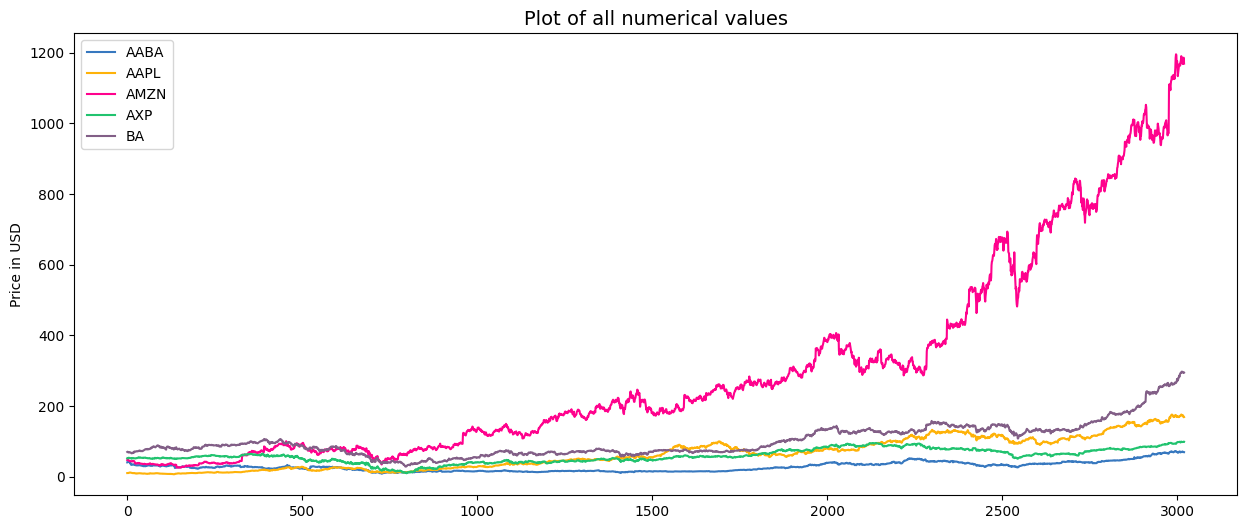

In [37]:
# Or graphically
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
fig = df.plot(kind='line')
plt.title('Plot of all numerical values', size=14)
plt.ylabel('Price in USD')
#plt.legend(f

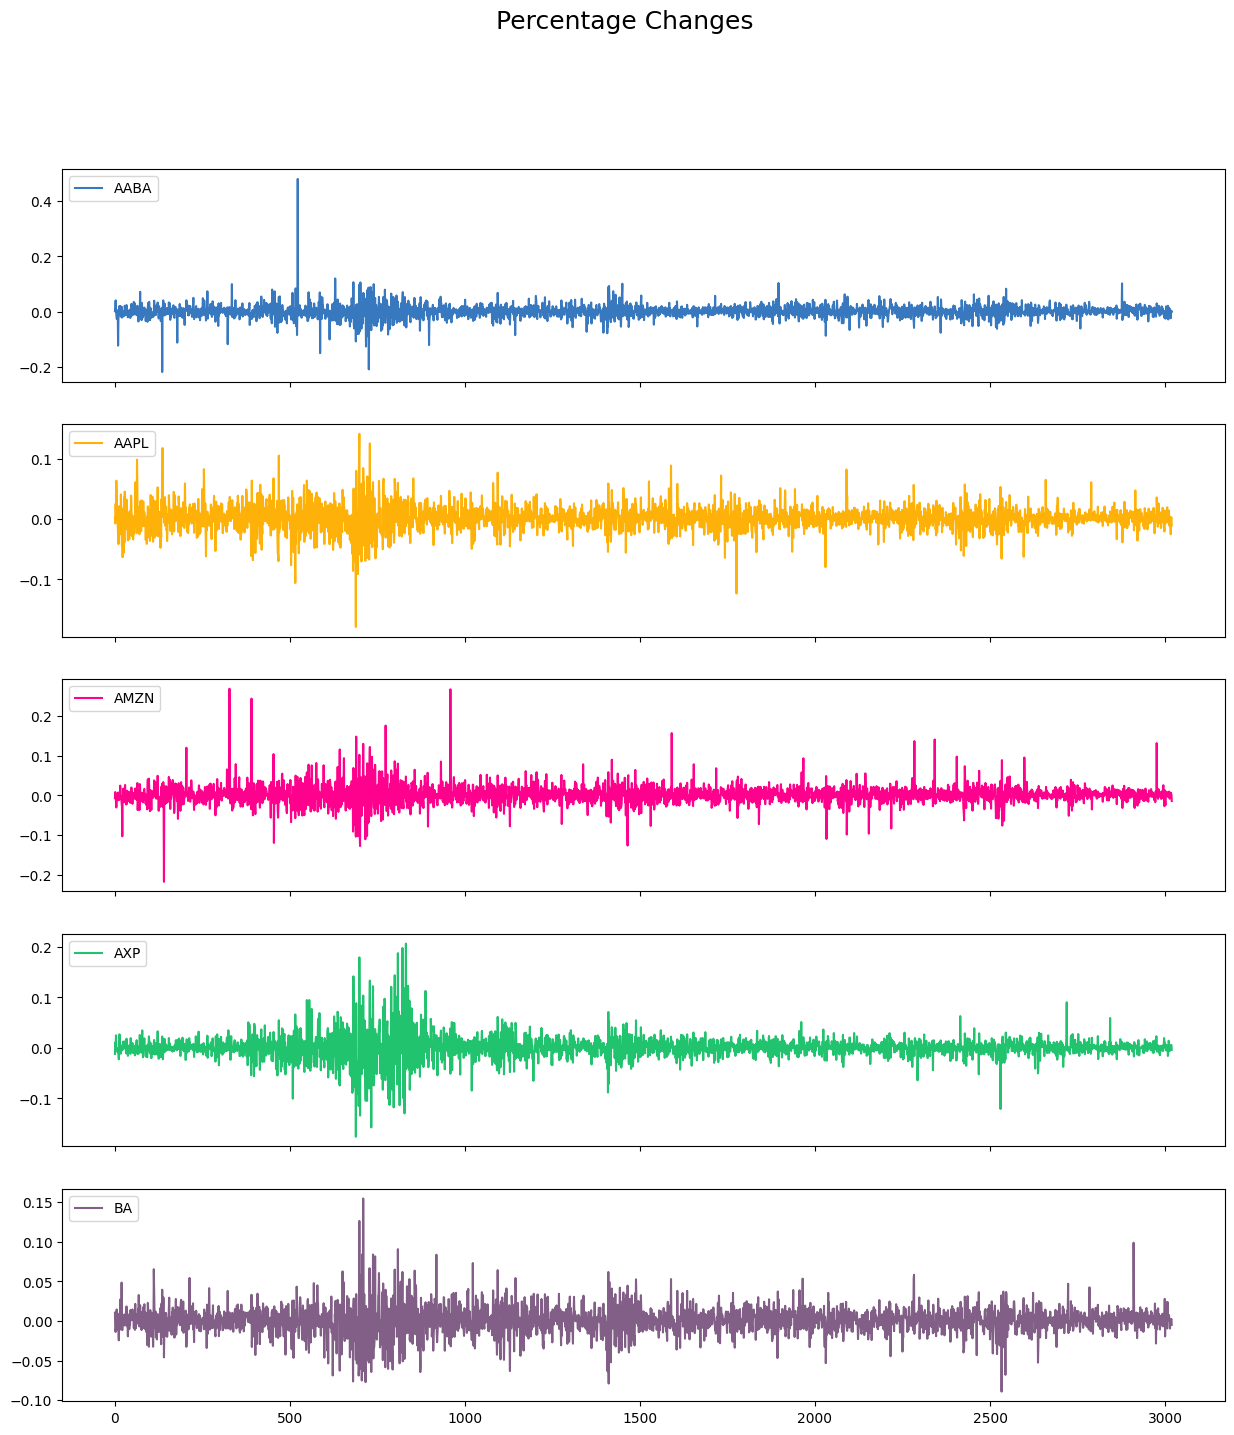

In [38]:
# Or graphically
%matplotlib inline
df_ = df.copy()

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_n = df_.select_dtypes(include=numerics)

plt.rcParams['figure.figsize'] = [15, 16]
fig = df_n.pct_change().plot(kind='line', subplots=True)
plt.suptitle('Percentage Changes', size=18)
[ax.legend(loc=2) for ax in plt.gcf().axes]

plt.show()

In [39]:
# Summary of differences
my_df_summary(df_n.pct_change())

,AABA,AAPL,AMZN,AXP,BA
Minimum,-0.218362,-0.179039,-0.21822,-0.175949,-0.08929
Maximum,0.479666,0.141304,0.269497,0.206485,0.154627
Mean,0.000468,0.001124,0.001373,0.00048,0.000627
Std. Deviation,0.024339,0.020418,0.025205,0.023259,0.017497
#NA,1,1,1,1,1
#Uniques,2957,2983,3012,3001,3009
dtypes,float64,float64,float64,float64,float64


## What is the frequency of the data?

In [40]:
df_ = df.copy()
s_Dates = pd.to_datetime(df_.iloc[:, 0], format='%Y-%m-%d')

# With "number" of the weekday
df_NuDay = pd.DataFrame(s_Dates.dt.dayofweek.value_counts(dropna=False))
df_NuDay = df_NuDay.reset_index()
df_NuDay.columns = ['Day', 'Count']

# With the "name" of the weekday
df_NaDay = pd.DataFrame(s_Dates.dt.day_name().value_counts(dropna=False))
df_NaDay = df_NaDay.reset_index()
df_NaDay.columns = ['Day', 'Count']



In [41]:
df_NaDay

,Day,Count
0,Wednesday,622
1,Tuesday,618
2,Thursday,609
3,Friday,605
4,Monday,566


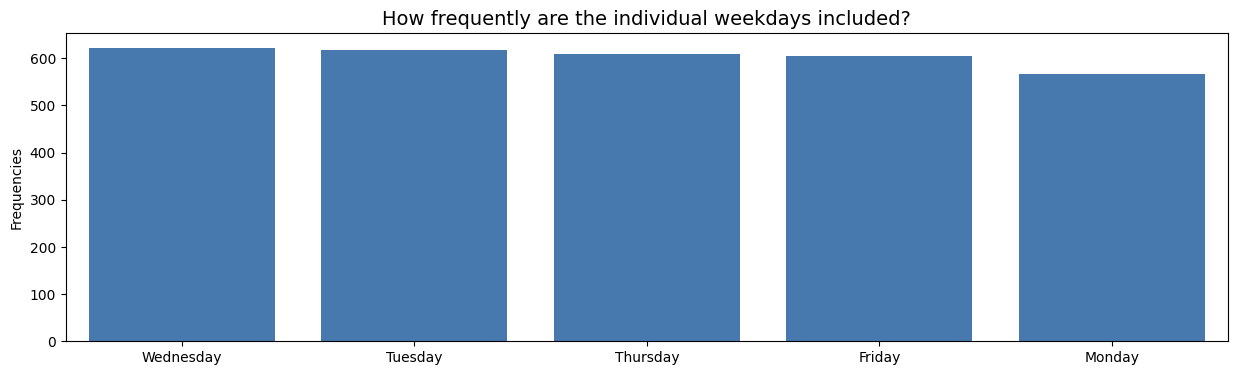

In [42]:
# Or graphically
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 4]
fig = sns.barplot(x='Day', y='Count', data=df_NaDay)
plt.title("How frequently are the individual weekdays included?", size=14)
plt.xlabel("")
plt.ylabel("Frequencies")
plt.show()


## Selecting a Time Series, because the processing should be done individually.

In [43]:
# This must be done individually for each time series!
# Step 0: Selecting a Time Series
df_ = df.iloc[:,0:2].copy() # column 0 with index, column 1 with date and column 2 with data

In [44]:
# Cleansing
# Step 1: only select business days
l_colnames = df_.columns.to_list()
l_colnames[0] = 'Date'
df_.columns = l_colnames
df_['Date'] = pd.to_datetime(df_['Date'], format='%Y-%m-%d')
daterange = pd.date_range(start=min(df_['Date']), end=max(df_['Date']), freq='B') #business days
df_ts = pd.DataFrame(daterange)
df_ts.columns = ['Date']
df_ts = df_ts.merge(df_, how='left', on='Date')

In [45]:
# Step 2
print('{} missing values are replaced by the last valid value.'.format(df_ts.iloc[:,1].isna().sum()))
df_ts = df_ts.ffill()
df_ts = df_ts.set_index('Date', drop=True)

110 missing values are replaced by the last valid value.


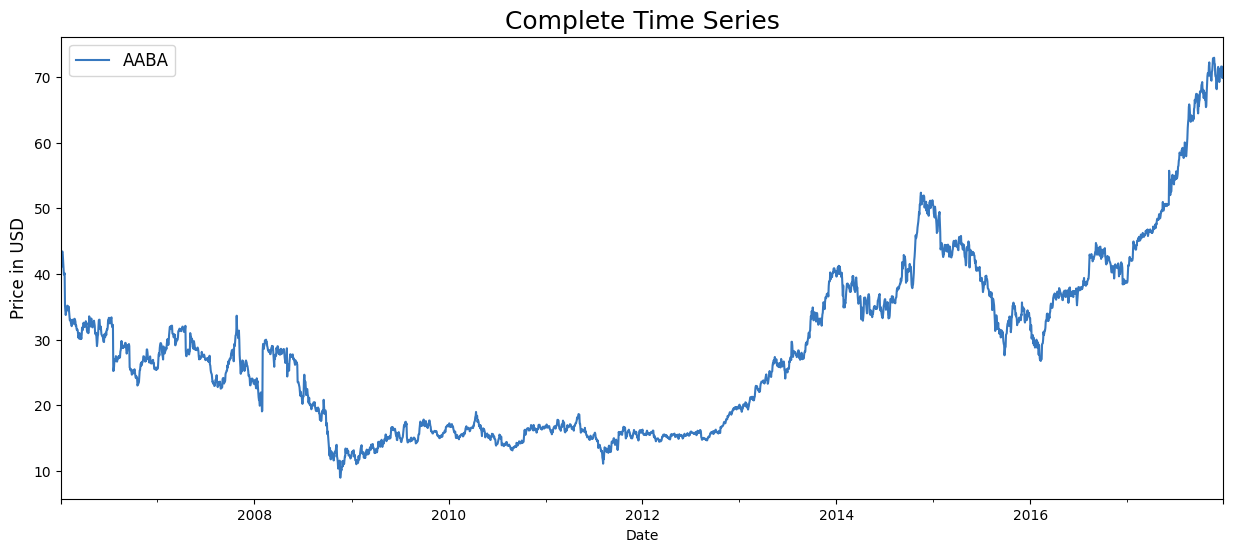

In [46]:
# Plotting the complete data
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
fig = df_ts.plot(kind='line')
plt.title('Complete Time Series', size=18)
plt.legend(fontsize=12)
plt.ylabel('Price in USD', size=12)
plt.show()

### Detecting Outliers

#### In time series, outliers are easiest to detect in percentage changes.

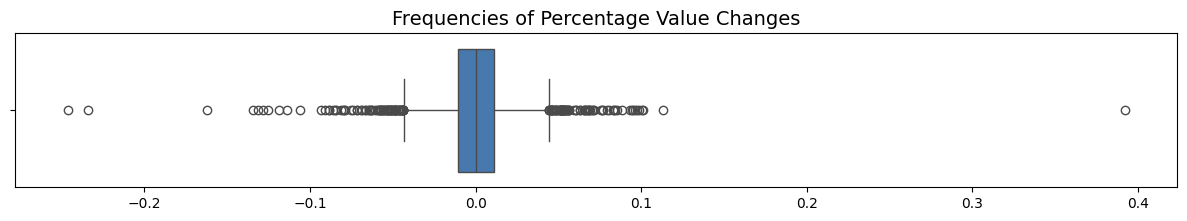

In [47]:
# Display Outliers - Do NOT remove for time series.
# Outliers in time series data are detected based on the behavior of percentage changes relative to the previous value.
%matplotlib inline
df_ = df.iloc[:,0:2].copy()
df_.iloc[:,1] = np.log(df_.iloc[:,1]) # Log differences represent the percentage changes
df_diff = df_.iloc[:,1].diff()

plt.rcParams['figure.figsize'] = [15, 2]

fig = sns.boxplot(data=df_diff, orient='h')

plt.title('Frequencies of Percentage Value Changes', size=14)
plt.xlabel('')
plt.show()


In [48]:
df_diff.describe()

count    3017.000000
mean        0.000178
std         0.024039
min        -0.246364
25%        -0.010587
50%         0.000364
75%         0.011320
max         0.391817
Name: AABA, dtype: float64

### Display Outliers - NOT necessarily to be removed for time series, but explain.
#### On which days did outliers occur?

In [49]:
i_iqr_factor = 2
df_ = df.iloc[:,0:2].copy()
df_['Date'] = pd.to_datetime(df_['Date'], format='%Y-%m-%d')
df_.iloc[:,1:] = np.log(df_.iloc[:,1:])
df_diff = df_.diff()
q25 = df_diff.iloc[:,1].quantile(0.25)
q75 = df_diff.iloc[:,1].quantile(0.75)
iqr = q75 - q25
lower_bound = q25 - (i_iqr_factor * iqr)
upper_bound = q75 + (i_iqr_factor * iqr)
outliers = df_[((df_diff.iloc[:,1] < lower_bound) | (df_diff.iloc[:,1] > upper_bound))]

df_dates = outliers.reset_index().iloc[:,[0,1]]

print('For the given data and the IQR factor, days where the value change was < {0:.2f} or > {1:.2f} are considered outliers.'.format(lower_bound, upper_bound))
print('This occurs on {} days:'.format(len(df_dates)))
df_dates


For the given data and the IQR factor, days where the value change was < -0.05 or > 0.06 are considered outliers.
This occurs on 89 days:


,index,Date
0,10,2006-01-18
1,73,2006-04-19
2,136,2006-07-19
3,179,2006-09-19
4,265,2007-01-24
5,323,2007-04-18
6,335,2007-05-04
7,450,2007-10-17
8,457,2007-10-26
9,458,2007-10-29


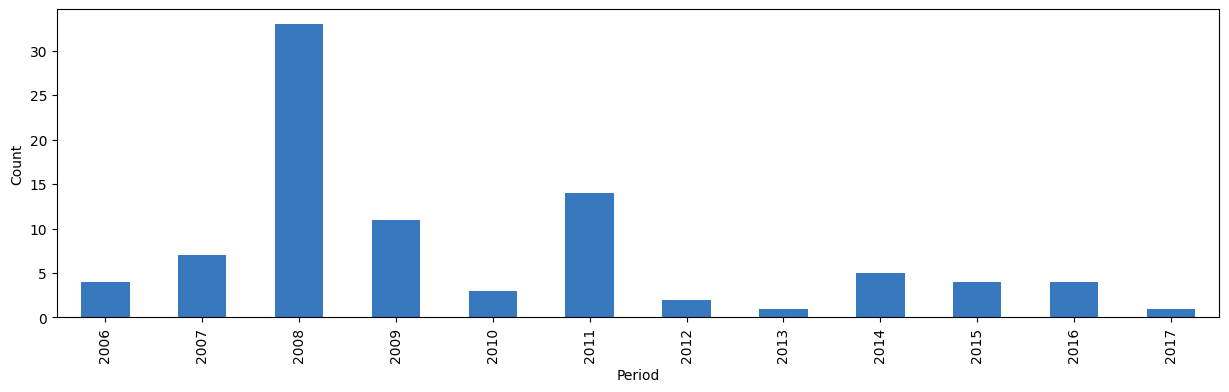

In [50]:
#Are specific years (months) particularly noticeable?
%matplotlib inline
df_dates['Year'] = df_dates['Date'].map(lambda x: x.strftime('%Y'))
plt.rcParams['figure.figsize'] = [15, 4]
df_dates.groupby('Year').size().plot(kind='bar')
plt.xlabel('Period')
plt.ylabel('Count')
plt.show()


In [51]:
df.head()

,Date,AABA,AAPL,AMZN,AXP,BA
0,2006-01-03,40.91,10.68,47.58,52.58,70.44
1,2006-01-04,40.97,10.71,47.25,51.95,71.17
2,2006-01-05,41.53,10.63,47.65,52.50,70.33
3,2006-01-06,43.21,10.90,47.87,52.68,69.35
4,2006-01-09,43.42,10.86,47.08,53.99,68.77


## Selecting data collected under similar conditions.

In [52]:
# Selecting Data to be Examined
df_ts_clean = df_ts[df_ts.index > '2013-12-31']
print('There are a total of {} contiguous similar observations.'.format(len(df_ts_clean)))

There are a total of 1043 contiguous similar observations.


## Splitting into Training and Testing Data

In [53]:
# Splitting into Training and Test Data - Typically, one starts with an 80:20 ratio.
# Since we have daily data and it's difficult to estimate more than 60 periods accurately with "classical" time series analysis methods, we split 95:5.
i_split = int(0.95 * len(df_ts_clean))
df_train, df_test = df_ts_clean.iloc[:i_split,:], df_ts_clean.iloc[i_split:,:]
print('Together, train and test are {} entries long.'.format(len(df_train) + len(df_test)))
print('That is, all forecasts must be {} periods long.'.format(len(df_test)))

Together, train and test are 1043 entries long.
That is, all forecasts must be 53 periods long.


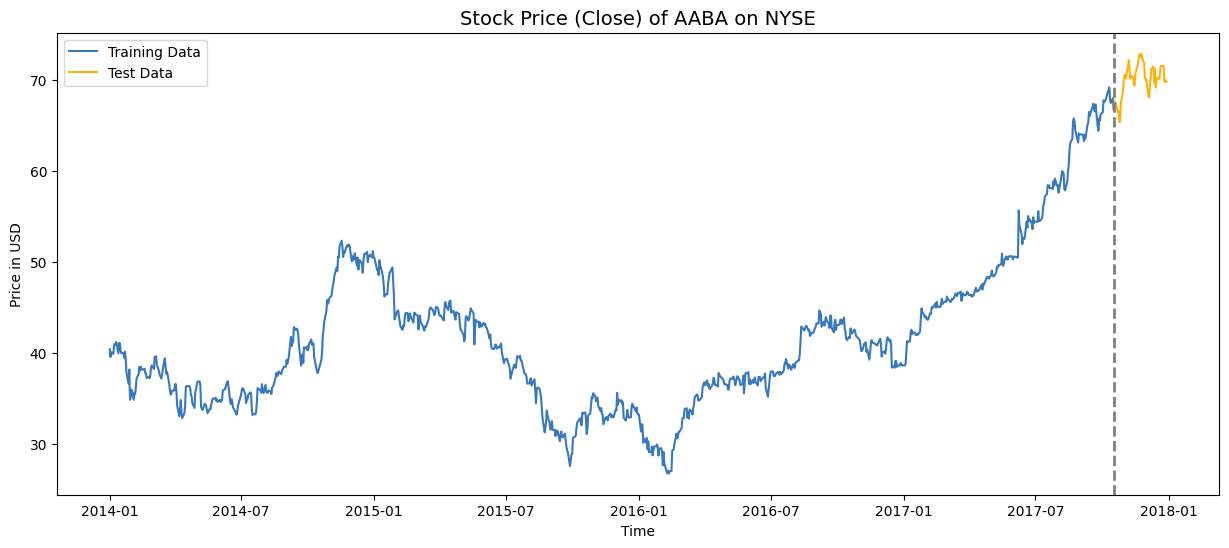

In [54]:
# Plot

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Training Data')
plt.plot(df_test.index, df_test.values, label='Test Data', color=colors[1])
plt.axvline(x = df_ts_clean.index[i_split], linewidth=2, color='grey', ls='--')
plt.legend(loc=2, fontsize=10)
plt.title('Stock Price (Close) of {} on NYSE'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Price in USD', fontsize=10)
plt.show()

## Factor Decomposition

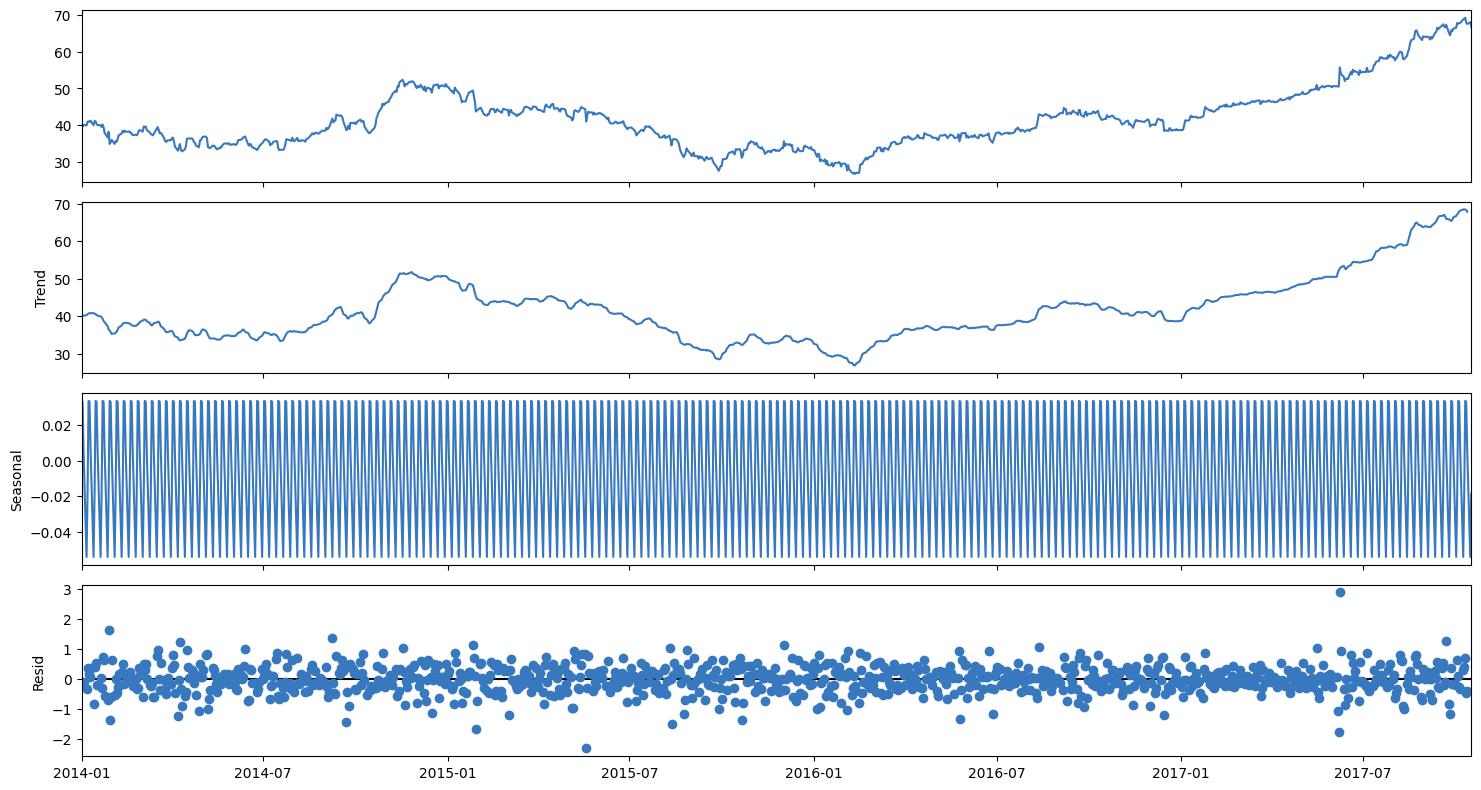

In [55]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
sm.tsa.seasonal_decompose(df_train, period= 5, model='additive').plot()
plt.show()

In [56]:
tsa_factors = sm.tsa.seasonal_decompose(df_train, period= 5, model='additive')

<Axes: title={'center': 'Residual'}, xlabel='Date'>

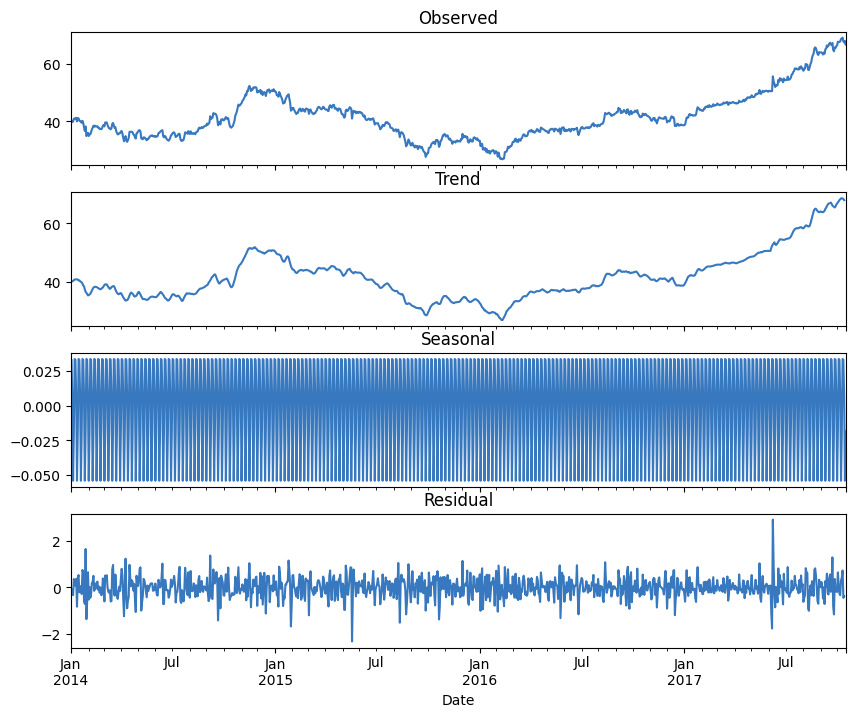

In [57]:
# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
tsa_factors.observed.plot(ax=ax1, title='Observed')
tsa_factors.trend.plot(ax=ax2, title='Trend')
tsa_factors.seasonal.plot(ax=ax3, title='Seasonal')
tsa_factors.resid.plot(ax=ax4, title='Residual')

## Forecasting Methods
## Naive Forecast - Simple continuation of the last value <br>


$\hat{y}_{t+1} = y_{t}  $


In [58]:
vals = np.asarray(df_train.values)
y_hat = df_test.copy()
y_hat['naive'] = vals[-1][0]

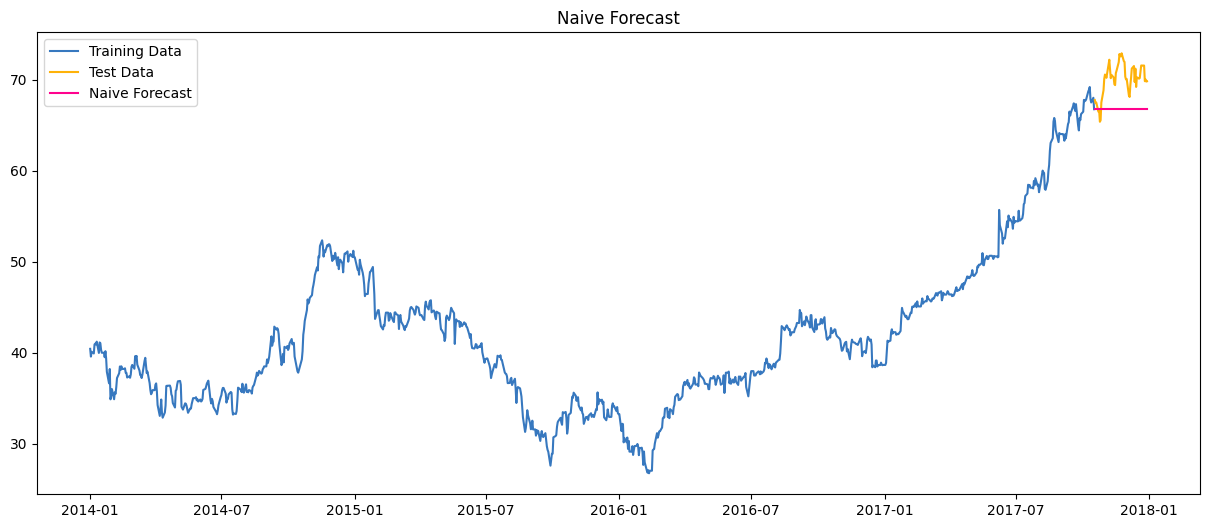

In [59]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Training Data')
plt.plot(df_test.index, df_test.values, label='Test Data')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

## How can we evaluate the accuracy of a forecast?

In [60]:
# Importing error estimation statistics from sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt #Importing a square root function from math

### Root Mean Squared Error - RMSE
<font size="4">
Tip: https://en.wikipedia.org/wiki/Root-mean-square_deviation <br>


\begin{align}
\text{RMSE}   \; &=  \sqrt{\frac{\sum_{t=1}^T (\hat{y}_t - y_t)^2}{T}}      
\end{align} 

Sometimes, one also simply looks at the average absolute error.

\begin{align*}
\text{ME}   \; &=  \frac{\sum_{t=1}^T (\hat{y}_t - y_t)}{T}
\end{align*} 

</font>

In [61]:
rmse = sqrt(mean_squared_error(df_test, y_hat.naive))
me = (df_test.iloc[:,0] - y_hat['naive']).sum() / len(df_test)
print('For the naive forecast, ME: {0:.4f} and RMSE: {1:.4f} result.'.format(me, rmse))

For the naive forecast, ME: 3.2947 and RMSE: 3.7385 result.


<font size=4>
One can also assess the accuracy of the forecast based on certain properties of the residuals (estimation errors).<br>

\begin{align*}
\text{Residuals}   \; &=  \hat{y}_t - y_t \quad = \epsilon_t
\end{align*}

</font>

In [62]:
residuen = (df_test.iloc[:,0] - y_hat['naive'])
print('The residuals for this forecast have the following standard deviation: {0:.4f}.'.format(residuen.std()))
stdres = residuen.std()

The residuals for this forecast have the following standard deviation: 1.7835.


In [63]:
#Creating a table to compare the accuracy of different methods later on.
#WARNING: This line creates an empty DataFrame.
df_Error = pd.DataFrame(columns=['Method', 'ME', 'RMSE', 'StdRes'])

In [65]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'Naive Extension', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [66]:
df_Error.head()

,Method,ME,RMSE,StdRes
0,Naive Extension,3.294717,3.73847,1.78354
1,Naive Extension,3.294717,3.73847,1.78354


### Analysis of Residuals
For some forecasting methods, it is necessary to also look at the distribution of residuals to ensure that the estimation was done correctly. This is especially true for regression-based models (such as ARIMA). It's not necessary for all methods, but it never hurts.


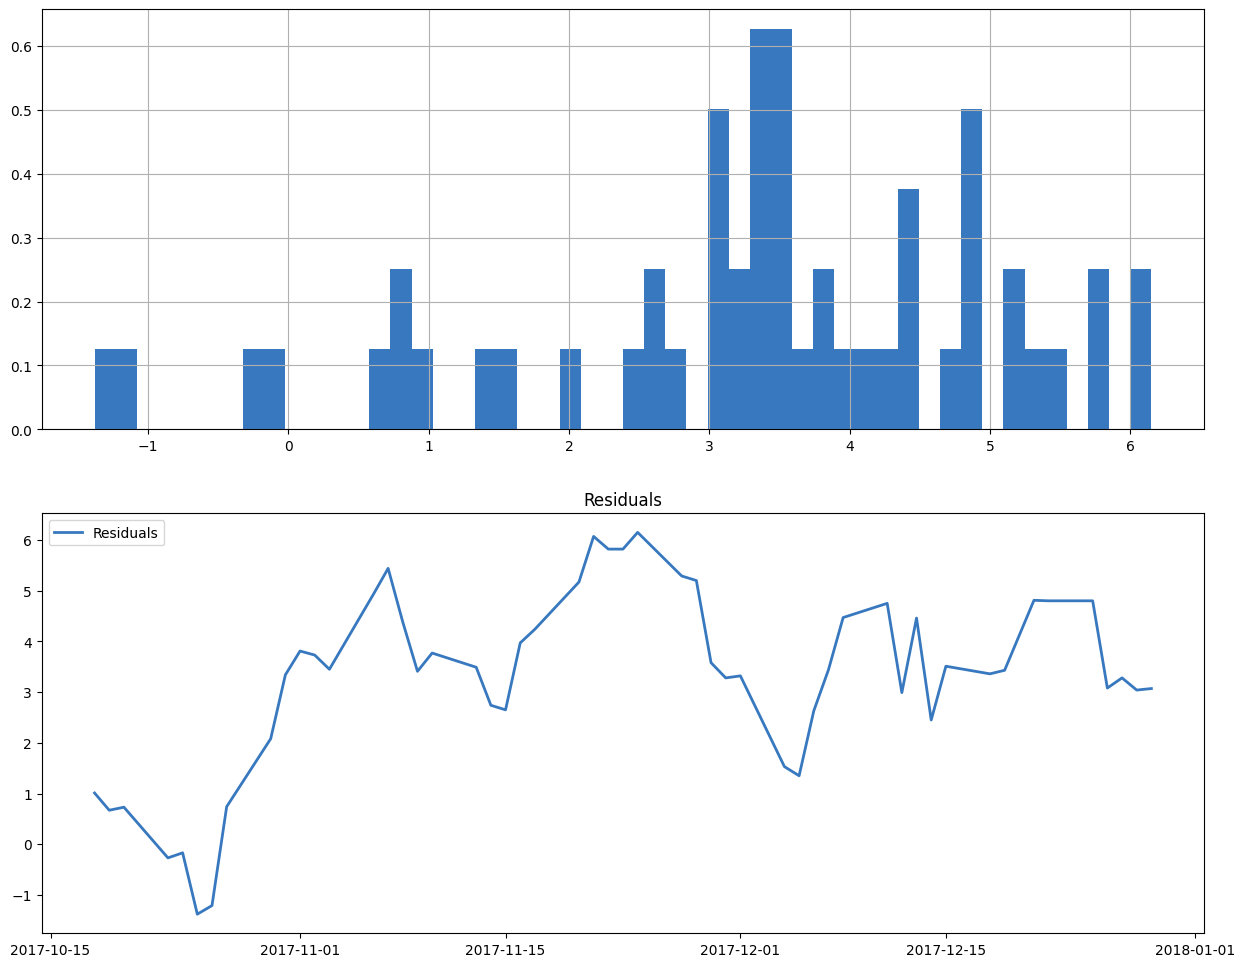

In [67]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.subplot(2,1,1)
residuen.hist(bins=50, density=True)
plt.subplot(2,1,2)
plt.plot(df_test.index, residuen.values, label='Residuals', linewidth=2)
plt.legend(loc=2)
plt.title("Residuals")
plt.show()


<fond size=4>To make an estimation "methodically acceptable," the estimation errors should be free from trends and "uniformly random" across the entire forecast. This means that the residuals should fluctuate around a value (ideally around zero) and exhibit a symmetric frequency distribution.

</font>

## Moving Average

With `rolling` and `mean()`, you can easily generate the moving average. Using a loop and `append`, you continue writing the values.


In [68]:
n = 60 # For example, the moving average over all trading days of the last quarter.
df_train.rolling(n).mean().iloc[-1][0]

np.float64(63.957166666666666)

In [69]:
n = 60
df_mav = df_train.copy()
for i in range(len(df_test)):
    df_mav = pd.concat([df_mav, pd.DataFrame([{df_mav.columns[0] : df_mav.rolling(n).mean().iloc[-1][0]}])], ignore_index=True)

In [70]:
y_hat = df_test.copy()
y_hat_mav = df_mav.iloc[-len(df_test):].copy()
y_hat['mav'] = y_hat_mav.values

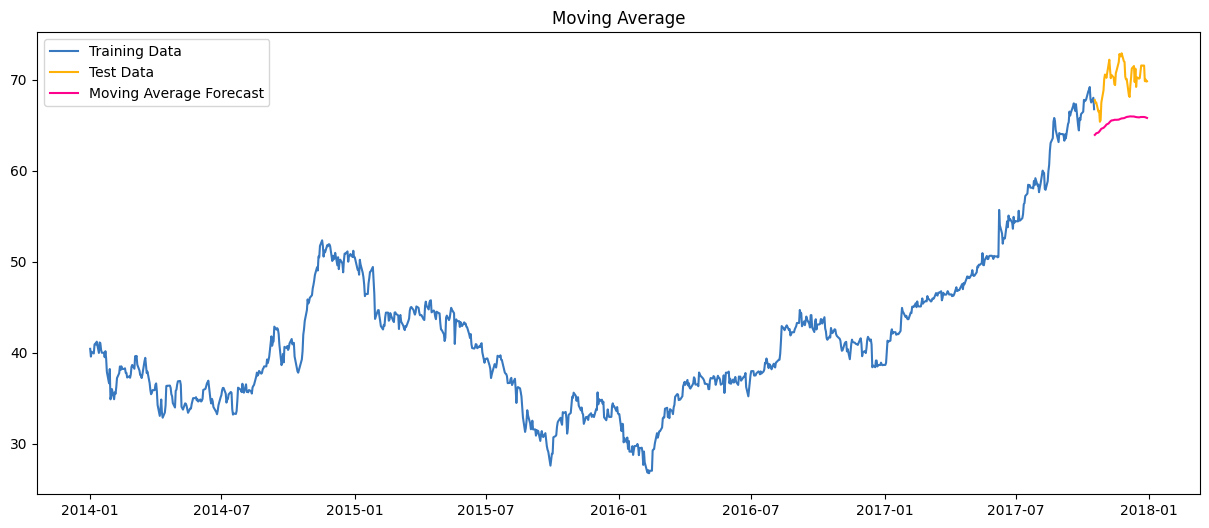

In [71]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Training Data')
plt.plot(df_test.index, df_test.values, label='Test Data')
plt.plot(df_test.index, y_hat['mav'].values, label='Moving Average Forecast')

plt.title('Moving Average')
plt.legend(loc='best')
plt.show()

In [72]:
rmse = sqrt(mean_squared_error(df_test, y_hat.mav))
me = (df_test.iloc[:,0] - y_hat['mav']).sum() / len(df_test)
print('For the naive forecast, ME: {0:.4f} and RMSE: {1:.4f}.'.format(me, rmse))

residuals = (df_test.iloc[:,0] - y_hat['mav'])
print('The residuals for this forecast have the following standard deviation: {0:.4f}.'.format(residuals.std()))
stdres = residuals.std()

For the naive forecast, ME: 4.6000 and RMSE: 4.8247.
The residuals for this forecast have the following standard deviation: 1.4691.


In [73]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'Moving Average', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [74]:
df_Error.head()

,Method,ME,RMSE,StdRes
0,Naive Extension,3.294717,3.738470,1.783540
1,Naive Extension,3.294717,3.738470,1.783540
2,Moving Average,4.600020,4.824714,1.469149


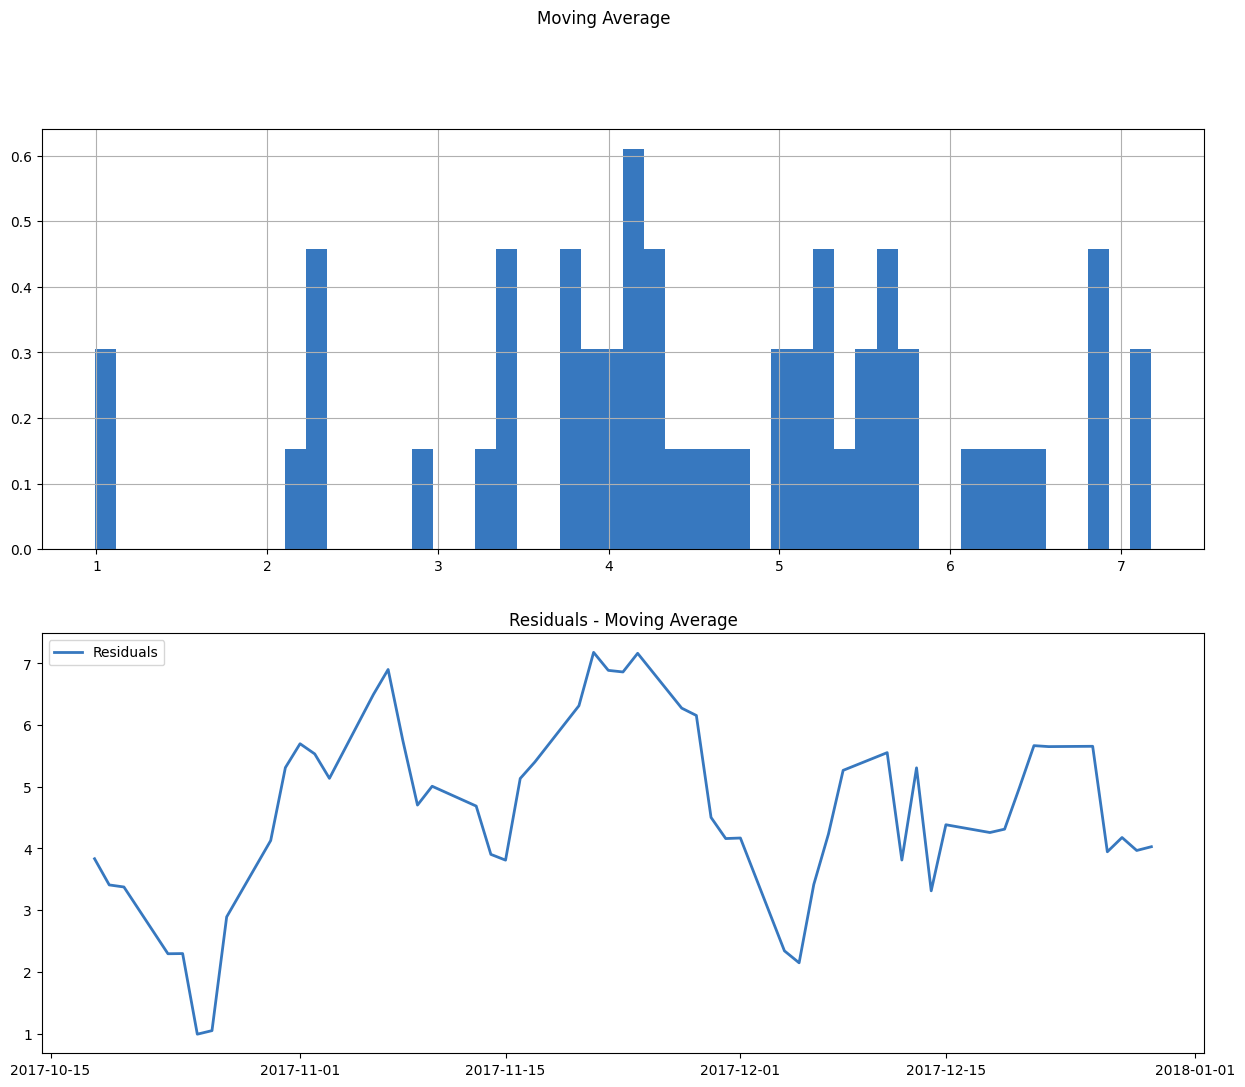

In [75]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.suptitle('Moving Average')
plt.subplot(2,1,1)
residuals.hist(bins=50, density=True)
plt.subplot(2,1,2)
plt.plot(df_test.index, residuals.values, label='Residuals', linewidth=2)
plt.legend(loc=2)
plt.title("Residuals - Moving Average")
plt.show()


## Exponential Smoothing

### Simple (naive) Exponential Smoothing

For simple exponential smoothing, we have:

\begin{align}
  \hat{y}_{t+1} &= \hat{y}_{t} + \alpha ( y_t - \hat{y}_{t})    
\end{align}

As $\alpha$ must be between 0 and 1, the equation can be rewritten as:

\begin{align}
  \hat{y}_{t+1} &=  \alpha y_t + (1-\alpha) \hat{y}_{t}    
\end{align}

Which can be further written as:

\begin{align}
  \hat{y}_{t+1} &= \alpha y_{t} + \alpha(1-\alpha) y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} + \cdots + \alpha(1-\alpha)^{t-1} y_{1} + \alpha(1-\alpha)^{t} {y}_{1} 
\end{align}

In [76]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [77]:
#Generating forecasts with different smoothing parameters
fit1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.25)
fcast1 = fit1.forecast(len(df_test)).rename(r'$\alpha=0.25$')


fit2 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.50)
fcast2 = fit2.forecast(len(df_test)).rename(r'$\alpha=0.50$')


fit3 = SimpleExpSmoothing(df_train).fit(smoothing_level=1)
fcast3 = fit3.forecast(len(df_test)).rename(r'$\alpha=%s$'%round(fit3.model.params['smoothing_level'],1))

In [78]:
#help for colors 
colors = sns.xkcd_palette(my_colors)

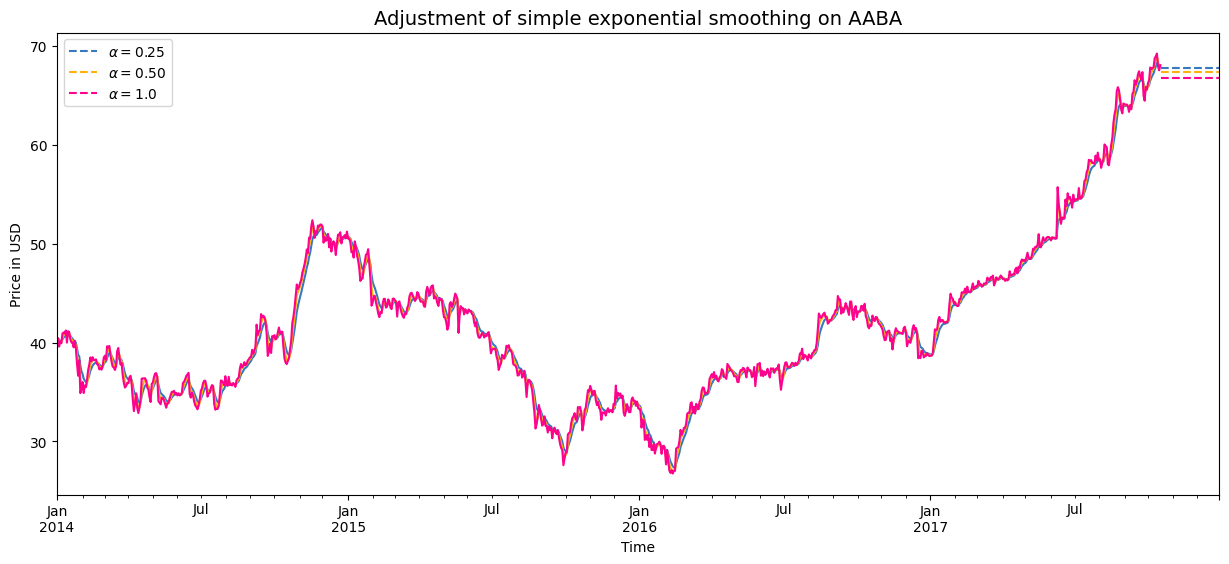

In [79]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 6]

fcast1.plot(legend=True, color=colors[0], ls='--')
fit1.fittedvalues.plot(color=colors[0])

fcast2.plot(legend=True, color=colors[1], ls='--')
fit2.fittedvalues.plot(color=colors[1])

fcast3.plot(legend=True, color=colors[2], ls='--')
fit3.fittedvalues.plot(color=colors[2])
plt.title('Adjustment of simple exponential smoothing on {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Price in USD', fontsize=10)

# Show the plot
plt.show()


In [80]:
len(fcast1.values)

53

In [81]:
rmse = sqrt(mean_squared_error(df_test, fcast1.values))
me = (df_test.iloc[:,0] - fcast1.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast1.values)
stdres = residuen.std()
print('Forecast 1   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 1   -   RMSE: 2.9550, ME: 2.3688, StdRes: 1.7835


In [82]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'SimpleExpSmooth 0.25', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [83]:
rmse = sqrt(mean_squared_error(df_test, fcast2.values))
me = (df_test.iloc[:,0] - fcast2.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast2.values)
stdres = residuen.std()
print('Forecast 2   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 2   -   RMSE: 3.2135, ME: 2.6843, StdRes: 1.7835


In [84]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'SimpleExpSmooth 0.5', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [85]:
rmse = sqrt(mean_squared_error(df_test, fcast3.values))
me = (df_test.iloc[:,0] - fcast3.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast3.values)
stdres = residuen.std()
print('Forecast 3   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 3   -   RMSE: 3.7385, ME: 3.2947, StdRes: 1.7835


In [86]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'SimpleExpSmooth 1', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [87]:
df_Error

,Method,ME,RMSE,StdRes
0,Naive Extension,3.294717,3.738470,1.783540
1,Naive Extension,3.294717,3.738470,1.783540
2,Moving Average,4.600020,4.824714,1.469149
3,SimpleExpSmooth 0.25,2.368758,2.954997,1.783540
4,SimpleExpSmooth 0.5,2.684340,3.213515,1.783540
5,SimpleExpSmooth 1,3.294717,3.738470,1.783540


### Exponential Smoothing with 'Level' and 'Trend' (Holt Method)

The Holt method, also known as double exponential smoothing, consists of:

\begin{align*}
\text{Level: }   \; \quad \ell_t &=  \alpha y_t + (1-\alpha) (\ell_{t-1} + b_{t-1}) \\ \\
\text{Growth: }   \; \quad b_t &= \beta^* (\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1} \\ \\
\text{Forecast: } \; \hat{y}_{t+h|t} &= \ell_t + b_t h \\ \\
\end{align*}

In [88]:
# Estimating double exponential smoothing
fit4 = Holt(df_train.iloc[:,0]).fit(smoothing_level=0.8, smoothing_slope=0.05)
fcast4 = fit4.forecast(len(df_test)).rename("Holt's linear trend")

fit5 = Holt(df_train.iloc[:,0], exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.01)
fcast5 = fit5.forecast(len(df_test)).rename("Exponential trend")

fit6 = Holt(df_train.iloc[:,0], damped=True, exponential=True).fit()
fcast6 = fit6.forecast(len(df_test)).rename("Additive damped trend")

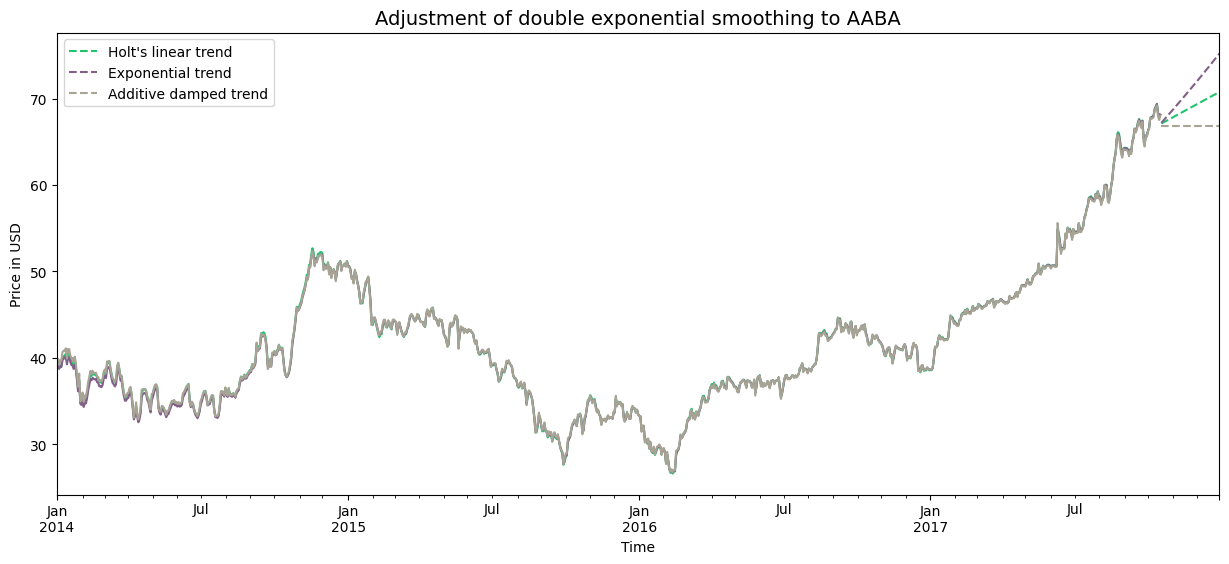

In [89]:
# Plotting the results

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

fcast4.plot(legend=True, color=colors[3], ls='--')
fit4.fittedvalues.plot(color=colors[3])

fcast5.plot(legend=True, color=colors[4], ls='--')
fit5.fittedvalues.plot(color=colors[4])

fcast6.plot(legend=True, color=colors[5], ls='--')
fit6.fittedvalues.plot(color=colors[5])

plt.title('Adjustment of double exponential smoothing to {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Price in USD', fontsize=10)

plt.show()

In [90]:
rmse = sqrt(mean_squared_error(df_test, fcast4.values))
me = (df_test.iloc[:,0] - fcast4.values).sum() / len(df_test)
residues = (df_test.iloc[:,0] - fcast4.values)
std_res = residues.std()
print('Forecast 4   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, std_res))

Forecast 4   -   RMSE: 1.9783, ME: 1.1299, StdRes: 1.6394


In [91]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'Holt LT', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [92]:
rmse = sqrt(mean_squared_error(df_test, fcast5.values))
me = (df_test.iloc[:,0] - fcast5.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast5.values)
stdres = residuen.std()
print('Forecast 5   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 5   -   RMSE: 2.5064, ME: -1.0628, StdRes: 2.2916


In [93]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'Holt ET', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [94]:
rmse = sqrt(mean_squared_error(df_test, fcast6.values))
me = (df_test.iloc[:,0] - fcast6.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast6.values)
stdres = residuen.std()
print('Forecast 6   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 6   -   RMSE: 3.7161, ME: 3.2694, StdRes: 1.7835


In [95]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'Holt add, damped trend', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [96]:
df_Error

,Method,ME,RMSE,StdRes
0,Naive Extension,3.294717,3.738470,1.783540
1,Naive Extension,3.294717,3.738470,1.783540
2,Moving Average,4.600020,4.824714,1.469149
3,SimpleExpSmooth 0.25,2.368758,2.954997,1.783540
4,SimpleExpSmooth 0.5,2.684340,3.213515,1.783540
5,SimpleExpSmooth 1,3.294717,3.738470,1.783540
6,Holt LT,1.129905,1.978303,1.783540
7,Holt ET,-1.062775,2.506362,2.291602
8,"Holt add, damped trend",3.269357,3.716139,1.783540





## Autoregressive Processes AR, ARMA, ARIMA, SARIMAX

### Autoregressive Forecast Models

ARIMA models explain a time series with a lagged term of the variable to be explained (AR) and a moving-average term (MA). Under certain conditions, the model must be optimized as an integrated equation (I; single or multiple differenced).

To achieve this, the optimal number of lags (p), the optimal momentum (q), and, if necessary, the optimal difference level (d) need to be found.

For ARIMA models, we have:

\begin{align*}
\text{Forecast:} \; \quad \hat{y}_{t} &=  \mu + \phi_{1}y{t-1}+\cdots+\phi_{p}y_{t-p}-\theta_{1}\epsilon_{t-1}-\cdots-\theta_{q}\epsilon_{t-q} \\\\
\text{For d = 0:} \; \quad y_t &= Y_t \\\\
\text{For d = 1:} \; \quad y_t &= Y_t - Y_{t-1} \\\\
\text{For d = 2:} \; \quad y_t &= (Y_t - Y_{t-1})-(Y_{t-1} - Y_{t-2})
\end{align*}



In [97]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore") # specify to ignore warning messages

NameError: name 'ts' is not defined

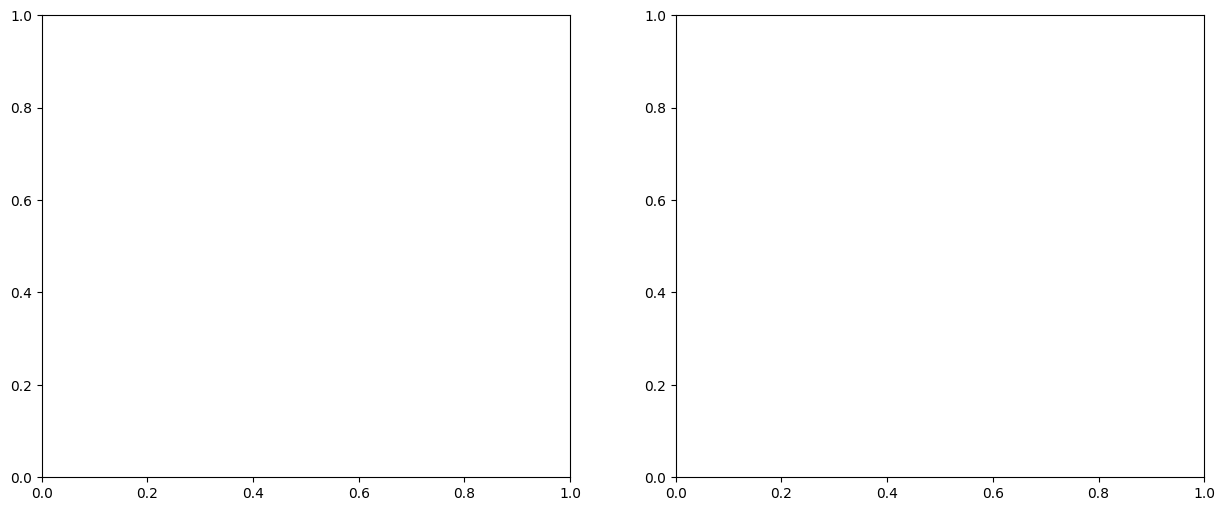

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Autocorrelation Function (ACF)
sm.graphics.tsa.plot_acf(ts, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

# Partial Autocorrelation Function (PACF)
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function')

In [99]:
# Custom Auto-Arima function
# Generating a list of all parameters to be tested.
q = d = range(0, 2)
p = range(0, 4)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1)]

In [100]:
ts = df_train.copy()

In [101]:
AIC = []
ARIMA_model = []
i = 0

for param in pdq:
    try:
        mod = ARIMA(ts, order=param)
        results = mod.fit()
        print(i, ": ",'ARIMA{} - AIC:{}'.format(param, results.aic), end='\r')
        AIC.append(results.aic)
        ARIMA_model.append([param])
    except:
        continue
    i = i + 1

In [102]:
print('The AIC takes the smallest value of {} for the ARIMA{} model.'.format(min(AIC), ARIMA_model[AIC.index(min(AIC))][0]))

The AIC takes the smallest value of 2150.5788207980204 for the ARIMA(0, 1, 0) model.


In [103]:
mod = ARIMA(ts,order=ARIMA_model[AIC.index(min(AIC))][0])
fit9 = mod.fit()

In [104]:
fcast9 = fit9.predict(start=len(ts), end=len(ts)+len(df_test)-1, dynamic=False)
fcast9.head()

2017-10-18    66.78
2017-10-19    66.78
2017-10-20    66.78
2017-10-23    66.78
2017-10-24    66.78
Freq: B, Name: predicted_mean, dtype: float64

In [105]:
y_hat_ = fcast9.copy()
fcast9[:] = y_hat_

In [106]:
rmse = sqrt(mean_squared_error(df_test, fcast9.values))
me = (df_test.iloc[:,0] - fcast9.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast9.values)
stdres = residuen.std()
print('Forecast 7   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 7   -   RMSE: 3.7385, ME: 3.2947, StdRes: 1.7835


In [107]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'ARIMA(0,1,0)', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [108]:
df_Error

,Method,ME,RMSE,StdRes
0,Naive Extension,3.294717,3.738470,1.783540
1,Naive Extension,3.294717,3.738470,1.783540
2,Moving Average,4.600020,4.824714,1.469149
3,SimpleExpSmooth 0.25,2.368758,2.954997,1.783540
4,SimpleExpSmooth 0.5,2.684340,3.213515,1.783540
5,SimpleExpSmooth 1,3.294717,3.738470,1.783540
6,Holt LT,1.129905,1.978303,1.783540
7,Holt ET,-1.062775,2.506362,2.291602
8,"Holt add, damped trend",3.269357,3.716139,1.783540
9,"ARIMA(0,1,0)",3.294717,3.738470,1.783540


In [109]:
fit9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AABA   No. Observations:                  990
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1074.289
Date:                Tue, 18 Jun 2024   AIC                           2150.579
Time:                        15:07:04   BIC                           2155.476
Sample:                    01-01-2014   HQIC                          2152.441
                         - 10-17-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5141      0.013     38.849      0.000       0.488       0.540
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               697.48
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

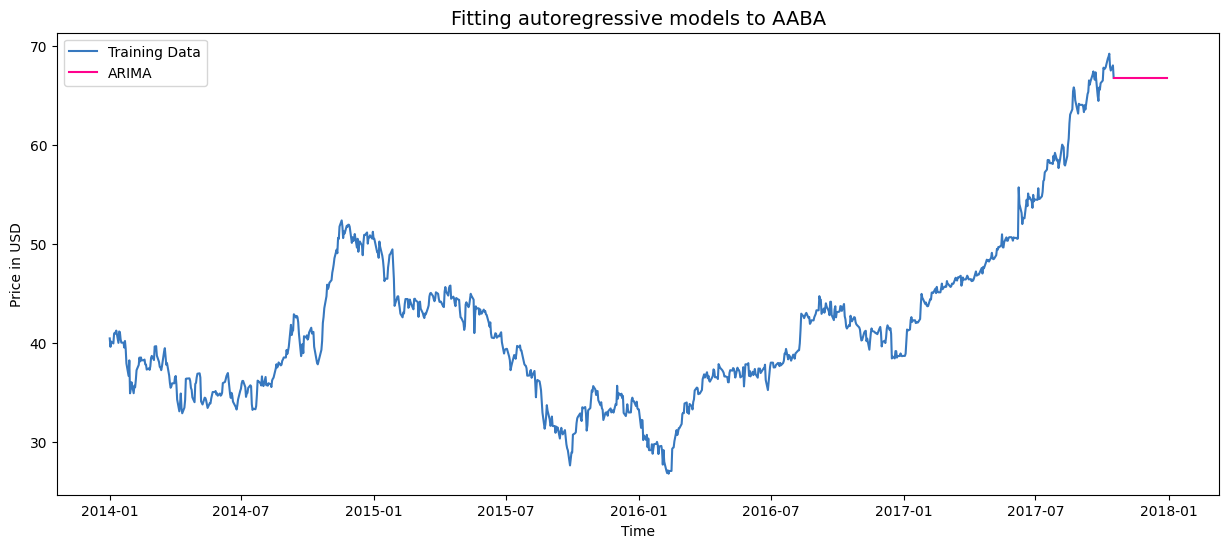

In [110]:
# Plotting the results
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Training Data')
plt.plot(fcast9.index, fcast9.values, label='ARIMA', color=colors[2])

plt.legend(loc=2)
plt.title('Fitting autoregressive models to {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Price in USD', fontsize=10)

plt.show()

#### Of course, seasonal effects can also be considered in AR models...

In [111]:
q = d = range(0, 2)
p = range(0, 4)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]

print('Now, all settings according to this scheme are being tested.')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print('...')

Now, all settings according to this scheme are being tested.
SARIMAX: (0, 0, 1) x (0, 0, 1, 5)
SARIMAX: (0, 0, 1) x (0, 1, 0, 5)
SARIMAX: (0, 1, 0) x (0, 1, 1, 5)
SARIMAX: (0, 1, 0) x (1, 0, 0, 5)
...


#### Finding the optimum parameters can take quite a while - about 3 minutes for me.

In [112]:
#%%time
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.16311D+00    |proj g|=  2.23590D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.236D-06   5.163D+00
  F =   5.1631066187449646     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:10224.95110511503

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83926D+00    |proj g|=  5.16162D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   1.346D-07   1.838D+00
  F =   1.8380459746099720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:3643.3310297277444

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bound

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83919D+00    |proj g|=  5.52210D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   3.550D-05   1.838D+00
  F =   1.8376524534503822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:3644.551857831757

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:3637.415989671974

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83126D+00    |proj g|=  4.96612D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.966D-06   1.831D+00
  F =   1.8312592158037793     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:3631.893247291483

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82513D+00    |proj g|=  3.70425D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     15      1     0     0   3.704D-03   1.825D+00
  F =   1.8251347909238047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:3621.7668860291333

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bound


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:3607.1850492193366

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80682D+00    |proj g|=  5.11167D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   5.112D-06   1.807D+00
  F =   1.8068235777217603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:3585.510683889085

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variab

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.67865D+00    |proj g|=  2.14671D-02

At iterate   10    f=  4.52381D+00    |proj g|=  2.60290D-01

At iterate   15    f=  4.01642D+00    |proj g|=  6.85828D-01

At iterate   20    f=  3.91589D+00    |proj g|=  2.38364D-01

At iterate   25    f=  3.91176D+00    |proj g|=  4.53548D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     51      1     0     0   5.856D-06   3.912D+00
  F =   3.9117599289217657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:7751.284659265096

           * * *

Machine precision = 2.220D-16
 N =      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.58910D+00    |proj g|=  3.00475D-01

At iterate   15    f=  1.56725D+00    |proj g|=  1.76368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     51      1     0     0   1.764D-03   1.567D+00
  F =   1.5672488367254707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:3109.152696716432

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77662D+00    |proj g|=  8.56996D-01

At iterate    5    f=  2.82307D+00    |pr

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:3044.846597175987

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76990D+00    |proj g|=  2.96146D+00

At iterate    5    f=  1.53340D+00    |proj g|=  7.31577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   5.124D-06   1.533D+00
  F =   1.5333541121612653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:3042.0411420793052

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE, 5) - AIC:3033.615743651392

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76207D+00    |proj g|=  8.54189D-01

At iterate    5    f=  2.67509D+00    |proj g|=  1.66603D+00


 This problem is unconstrained.



At iterate   10    f=  1.57253D+00    |proj g|=  2.24390D+00

At iterate   15    f=  1.53066D+00    |proj g|=  3.80125D-01

At iterate   20    f=  1.52853D+00    |proj g|=  1.35723D-02

At iterate   25    f=  1.52840D+00    |proj g|=  2.91281D-02

At iterate   30    f=  1.52776D+00    |proj g|=  8.63178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     73      1     0     0   4.781D-04   1.528D+00
  F =   1.5277635753242034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:3034.9718791419227

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.52566D+00    |proj g|=  5.65161D-03

At iterate   10    f=  1.52541D+00    |proj g|=  1.63001D-02

At iterate   15    f=  1.52246D+00    |proj g|=  7.97252D-03

At iterate   20    f=  1.52239D+00    |proj g|=  6.89879D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   6.899D-06   1.522D+00
  F =   1.5223881320330177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:3024.328501425375

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are ex

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  4.73775D+00    |proj g|=  8.50005D-01
  ys=-1.194E+00  -gs= 1.201E+00 BFGS update SKIPPED

At iterate    5    f=  3.74223D+00    |proj g|=  9.56948D-01

At iterate   10    f=  2.24755D+00    |proj g|=  1.20925D+01

At iterate   15    f=  1.73519D+00    |proj g|=  2.29078D+00

At iterate   20    f=  1.52756D+00    |proj g|=  6.19897D-01

At iterate   25    f=  1.51983D+00    |proj g|=  2.66483D-02

At iterate   30    f=  1.51953D+00    |proj g|=  2.07206D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     66      1     1     0   4.623D-04   1.520D+00
  F =   1.5195184849695662     

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78343D+00    |proj g|=  3.51938D+00

At iterate    5    f=  1.50664D+00    |proj g|=  1.04458D-02

At iterate   10    f=  1.50315D+00    |proj g|=  2.91025D-02

At iterate   15    f=  1.50195D+00    |proj g|=  2.34689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     23      1     0     0   6.811D-06   1.502D+00
  F =   1.5019474579484671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07793D+00    |proj g|=  2.44900D-02

At iterate    5    f=  1.07743D+00    |proj g|=  3.05530D-02

At iterate   10    f=  1.07672D+00    |proj g|=  1.49774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   2.115D-06   1.077D+00
  F =   1.0766982696583078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2137.8625739234494

           * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20183D+00    |proj g|=  1.49088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   1.491D-05   1.202D+00
  F =   1.2018343965844325     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE, 5) - AIC:2385.6321052371763

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bound

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     29      1     0     0   1.908D-03   1.080D+00
  F =   1.0799391117923836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2146.2794413489196

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06900D+00    |proj g|=  1.91254D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
S

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06845D+00    |proj g|=  3.02066D-02

At iterate    5    f=  1.06811D+00    |proj g|=  2.38261D-03

At iterate   10    f=  1.06792D+00    |proj g|=  3.55771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   5.229D-06   1.068D+00
  F =   1.0679107422427450     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2124.463269640635

           * * 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


At iterate    0    f=  1.13929D+00    |proj g|=  1.45077D-01

At iterate    5    f=  1.10143D+00    |proj g|=  1.52454D-01

At iterate   10    f=  1.07689D+00    |proj g|=  1.90704D-02

At iterate   15    f=  1.06605D+00    |proj g|=  1.05278D+00

At iterate   20    f=  1.06450D+00    |proj g|=  1.55724D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     52      1     0     0   1.496D-02   1.064D+00
  F =   1.0644995126535692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2117.709035054067

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2141.20711619047

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43132D+00    |proj g|=  1.76236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   6.100D-08   1.431D+00
  F =   1.4313175298560650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2838.0087091150085

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2143.901035903877

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07728D+00    |proj g|=  2.37019D-02

At iterate    5    f=  1.07705D+00    |proj g|=  6.01051D-03

At iterate   10    f=  1.07619D+00    |proj g|=  2.45091D-02

At iterate   15    f=  1.07600D+00    |proj g|=  3.22348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     25      1     0     0   2.655D-06   1.076D+00
  F =   1.0759969141409733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.08474D+00    |proj g|=  3.44864D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.865D-05   1.085D+00
  F =   1.0847384689560104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2155.782168532901

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07387D+00    |proj g|=  2.17806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  1.20926D+00    |proj g|=  4.14036D-01

At iterate    5    f=  1.08401D+00    |proj g|=  5.16693D-02
  ys=-9.585E-05  -gs= 2.853E-04 BFGS update SKIPPED

At iterate   10    f=  1.07981D+00    |proj g|=  1.35129D-02

At iterate   15    f=  1.07969D+00    |proj g|=  7.04303D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     30      1     1     0   5.431D-05   1.080D+00
  F =   1.0796898379904500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2147.785879221091

           * * *

Machine precision = 2.220D-16
 N =            5   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06792D+00    |proj g|=  1.90014D-03

At iterate   10    f=  1.06780D+00    |proj g|=  7.43401D-03

At iterate   15    f=  1.06777D+00    |proj g|=  1.22772D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     21      1     0     0   8.426D-06   1.068D+00
  F =   1.0677698957546147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2126.184393594137

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21452D+00    |pr

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20345D+00    |proj g|=  4.10007D-01

At iterate    5    f=  1.10894D+00    |proj g|=  1.09879D-01

At iterate   10    f=  1.07985D+00    |proj g|=  1.13126D-01

At iterate   15    f=  1.07660D+00    |proj g|=  2.26002D-03

At iterate   20    f=  1.07660D+00    |proj g|=  4.84378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     37      1     0     0   1.552D-05   1.077D+00
  F =   1.0765964737656080     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.41344D+00    |proj g|=  3.78606D-01

At iterate   10    f=  1.21881D+00    |proj g|=  2.23518D+00

At iterate   15    f=  1.13196D+00    |proj g|=  5.30998D+00

At iterate   20    f=  1.09810D+00    |proj g|=  1.09510D+00

At iterate   25    f=  1.08985D+00    |proj g|=  7.15874D-01

At iterate   30    f=  1.08488D+00    |proj g|=  7.45499D-01

At iterate   35    f=  1.08299D+00    |proj g|=  5.35615D-01

At iterate   40    f=  1.08176D+00    |proj g|=  2.89083D-01

At iterate   45    f=  1.08110D+00    |proj g|=  8.96936D-01

At iterate   50    f=  1.08066D+00    |proj g|=  2.20552D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2158.522336222907

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60066D+00    |proj g|=  1.45640D+00

At iterate    5    f=  1.36970D+00    |proj g|=  5.00864D-01

At iterate   10    f=  1.28304D+00    |proj g|=  4.40684D-01

At iterate   15    f=  1.08153D+00    |proj g|=  1.61274D+00

At iterate   20    f=  1.07923D+00    |proj g|=  2.75182D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     66      2     0     0   1.734D-04   1.079D+00
  F =   1.07

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51325D+00    |proj g|=  1.21233D+00

At iterate    5    f=  1.23685D+00    |proj g|=  1.14395D+00

At iterate   10    f=  1.16919D+00    |proj g|=  1.61016D+00

At iterate   15    f=  1.07678D+00    |proj g|=  9.19785D-02

At iterate   20    f=  1.07668D+00    |proj g|=  1.19949D-01

At iterate   25    f=  1.07663D+00    |proj g|=  1.28883D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     79      2     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2160.9706319201755

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49139D+00    |proj g|=  1.16669D+00

At iterate    5    f=  1.28439D+00    |proj g|=  2.85572D-01

At iterate   10    f=  1.24363D+00    |proj g|=  6.26159D-02

At iterate   15    f=  1.24240D+00    |proj g|=  1.29712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   2.116D-04   1.242D+00
  F =   1.2424011590069974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.21949D+00    |proj g|=  6.54828D-01

At iterate   10    f=  1.15915D+00    |proj g|=  1.51978D-01

At iterate   15    f=  1.08234D+00    |proj g|=  2.00389D-01

At iterate   20    f=  1.07226D+00    |proj g|=  9.29055D-01

At iterate   25    f=  1.07128D+00    |proj g|=  6.19935D-02

At iterate   30    f=  1.07127D+00    |proj g|=  5.46451D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   3.723D-03   1.071D+00
  F =   1.0712734153346068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2131.1213623625

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.14464D+00    |proj g|=  7.28644D-02

At iterate   10    f=  1.08993D+00    |proj g|=  1.25678D-01

At iterate   15    f=  1.07993D+00    |proj g|=  1.19174D-01

At iterate   20    f=  1.07992D+00    |proj g|=  1.14647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     36      1     0     0   4.369D-06   1.080D+00
  F =   1.0799245058546232     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2148.2505215921537

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50117D+00    |proj g|=  1.20928D+00

At iterate    5    f=  1.18827D+00    |proj g|=  2.27377D-01

At iterate   10    f=  1.14230D+00    |proj g|=  1.76673D-01

At iterate   15    f=  1.11372D+00    |proj g|=  1.62539D+00

At iterate   20    f=  1.08068D+00    |proj g|=  5.67023D-01

At iterate   25    f=  1.07146D+00    |proj g|=  6.50998D-02

At iterate   30    f=  1.06708D+00    |proj g|=  3.00437D-01

At iterate   35    f=  1.06677D+00    |proj g|=  2.43036D-03

At iterate   40    f=  1.06675D+00    |proj g|=  1.97054D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2263.168761458238

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32965D+00    |proj g|=  3.90192D-01

At iterate    5    f=  1.12299D+00    |proj g|=  6.19282D-02

At iterate   10    f=  1.10764D+00    |proj g|=  3.04774D-01

At iterate   15    f=  1.08629D+00    |proj g|=  1.15111D-01
  ys=-6.736E-03  -gs= 2.853E-03 BFGS update SKIPPED

At iterate   20    f=  1.06635D+00    |proj g|=  2.26540D-01

At iterate   25    f=  1.06574D+00    |proj g|=  6.80666D-02

At iterate   30    f=  1.06569D+00    |proj g|=  6.92555D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F    

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73198D+00    |proj g|=  3.62528D+00

At iterate    5    f=  1.41299D+00    |proj g|=  3.75207D-01

At iterate   10    f=  1.21426D+00    |proj g|=  2.09323D+00

At iterate   15    f=  1.12568D+00    |proj g|=  2.54052D-01

At iterate   20    f=  1.10556D+00    |proj g|=  8.48837D-01

At iterate   25    f=  1.08751D+00    |proj g|=  1.25137D+00

At iterate   30    f=  1.08481D+00    |proj g|=  6.89233D-02

At iterate   35    f=  1.08428D+00    |proj g|=  5.89707D-01

At iterate   40    f=  1.08228D+00    |proj g|=  3.65951D-01

At iterate   45    f=  1.08126D+00    |proj g|=  1.44280D-01

At iterate   50    f=  1.08054D+00    |proj g|=  4.87815D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34652D+00    |proj g|=  4.02586D-01

At iterate    5    f=  1.10490D+00    |proj g|=  1.67674D-01

At iterate   10    f=  1.09013D+00    |proj g|=  9.52356D-02

At iterate   15    f=  1.08558D+00    |proj g|=  4.50455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     69      2     0     0   1.626D-04   1.086D+00
  F =   1.0855778450777558     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51273D+00    |proj g|=  1.21320D+00

At iterate    5    f=  1.23309D+00    |proj g|=  7.51767D-01

At iterate   10    f=  1.15337D+00    |proj g|=  4.27195D+00

At iterate   15    f=  1.07830D+00    |proj g|=  9.95271D-01

At iterate   20    f=  1.07575D+00    |proj g|=  2.50905D-02

At iterate   25    f=  1.07571D+00    |proj g|=  3.90782D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34657D+00    |proj g|=  3.96572D-01

At iterate    5    f=  1.13232D+00    |proj g|=  2.01156D-01

At iterate   10    f=  1.09610D+00    |proj g|=  9.07802D-01

At iterate   15    f=  1.08640D+00    |proj g|=  1.21077D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   1.142D-04   1.086D+00
  F =   1.0858904016941311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51005D+00    |proj g|=  1.21802D+00

At iterate    5    f=  1.21975D+00    |proj g|=  5.79689D-01

At iterate   10    f=  1.15850D+00    |proj g|=  1.55867D-01

At iterate   15    f=  1.08499D+00    |proj g|=  3.28577D-01

At iterate   20    f=  1.07426D+00    |proj g|=  3.45184D-01

At iterate   25    f=  1.07135D+00    |proj g|=  1.95774D-02

At iterate   30    f=  1.07128D+00    |proj g|=  1.80335D-02

At iterate   35    f=  1.07116D+00    |proj g|=  6.44025D-02

At iterate   40    f=  1.07110D+00    |proj g|=  7.32038D-03

At iterate   45    f=  1.07110D+00    |proj g|=  3.67975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.14116D+00    |proj g|=  7.33511D-02

At iterate   10    f=  1.09566D+00    |proj g|=  1.19923D-01

At iterate   15    f=  1.07974D+00    |proj g|=  5.53791D-02

At iterate   20    f=  1.07968D+00    |proj g|=  5.63750D-03

At iterate   25    f=  1.07968D+00    |proj g|=  1.89144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     38      1     0     0   1.891D-04   1.080D+00
  F =   1.0796781759210528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48490D+00    |proj g|=  1.16314D+00

At iterate    5    f=  1.24888D+00    |proj g|=  3.34727D-01

At iterate   10    f=  1.19088D+00    |proj g|=  6.23001D-01

At iterate   15    f=  1.17841D+00    |proj g|=  4.09877D-02

At iterate   20    f=  1.17732D+00    |proj g|=  8.87179D-04

At iterate   25    f=  1.17732D+00    |proj g|=  8.34710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     29      1     0     0   

 This problem is unconstrained.



At iterate   15    f=  1.12203D+00    |proj g|=  4.56040D-01

At iterate   20    f=  1.07450D+00    |proj g|=  3.83920D-01

At iterate   25    f=  1.06896D+00    |proj g|=  1.46232D-01

At iterate   30    f=  1.06742D+00    |proj g|=  1.17723D-01

At iterate   35    f=  1.06723D+00    |proj g|=  1.23062D-01

At iterate   40    f=  1.06670D+00    |proj g|=  1.44437D-01

At iterate   45    f=  1.06666D+00    |proj g|=  3.10992D-03

At iterate   50    f=  1.06663D+00    |proj g|=  5.13165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   5.132D-03   1.067D+00
  F =   1.06662726645

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2264.833861338161

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32375D+00    |proj g|=  3.75480D-01

At iterate    5    f=  1.12250D+00    |proj g|=  5.18727D-02

At iterate   10    f=  1.11489D+00    |proj g|=  1.26558D-01

At iterate   15    f=  1.07507D+00    |proj g|=  6.18383D-01

At iterate   20    f=  1.06695D+00    |proj g|=  2.11194D-01

At iterate   25    f=  1.06565D+00    |proj g|=  5.92358D-02

At iterate   30    f=  1.06559D+00    |proj g|=  2.17967D-02

At iterate   35    f=  1.06559D+00    |proj g|=  8.74218D-02

At iterate   40    f=  1.06559D+00    |proj g|=  3.90896D-02

At iterate   45    f=  1.06559D+00    |proj g|=  3.95512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2142.567150439506

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43229D+00    |proj g|=  9.49261D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   9.493D-06   1.432D+00
  F =   1.4322926859877561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2839.939518255757

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.07689D+00    |proj g|=  1.28889D-02

At iterate   15    f=  1.07684D+00    |proj g|=  1.45434D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   1.454D-05   1.077D+00
  F =   1.0768353836120388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2140.134059551837

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29708D+00    |proj g|=  2.49902D-01

At iterate    5    f=  1.27671D+00    |pr

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2158.0664750531014

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07275D+00    |proj g|=  3.52514D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      7      1     0     0   2.649D-06   1.073D+00
  F =   1.0727471592803501     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2132.039375375093

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variab

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   4.007D-06   1.201D+00
  F =   1.2005411921088225     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2385.0715603754684

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20771D+00    |proj g|=  4.12461D-01

At iterate    5    f=  1.08707D+00    |proj g|=  9.74643D-02

At iterate   10    f=  1.07894D+00    |proj g|=  1.18001D-01

At iterate   15    f=  1.07885D+00    |p


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.06707D+00    |proj g|=  2.19066D-03

At iterate   10    f=  1.06691D+00    |proj g|=  6.69786D-03

At iterate   15    f=  1.06689D+00    |proj g|=  5.19623D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   6.644D-06   1.067D+00
  F =   1.0668894892063321     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2124.4411886285375

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21268D+00    |pr

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2300.1384576494693

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20153D+00    |proj g|=  4.09346D-01

At iterate    5    f=  1.10756D+00    |proj g|=  1.09899D-01

At iterate   10    f=  1.08001D+00    |proj g|=  1.13763D-01

At iterate   15    f=  1.07498D+00    |proj g|=  2.80643D-03

At iterate   20    f=  1.07497D+00    |proj g|=  4.35855D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     29      1     0     0   4.359D-05   1.075D+00
  F =   1.0

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43844D+00    |proj g|=  1.44445D+00

At iterate    5    f=  1.42486D+00    |proj g|=  1.33461D-01

At iterate   10    f=  1.42209D+00    |proj g|=  3.90547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   3.666D-06   1.422D+00
  F =   1.4220846297885930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2821.727566981414

           * * 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2153.668125925843

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15141D+00    |proj g|=  1.18390D+00

At iterate    5    f=  1.07800D+00    |proj g|=  1.02173D-02

At iterate   10    f=  1.07794D+00    |proj g|=  6.98838D-04

At iterate   15    f=  1.07794D+00    |proj g|=  4.02625D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   5.230D-06   1.078D+00
  F =   1.0779387599299008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08466D+00    |proj g|=  7.14650D-02

At iterate   10    f=  1.08342D+00    |proj g|=  8.99595D-03

At iterate   15    f=  1.08333D+00    |proj g|=  1.42225D-02

At iterate   20    f=  1.08330D+00    |proj g|=  5.19105D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   5.191D-06   1.083D+00
  F =   1.0833040936465428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2154.942105420155

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are ex

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.07297D+00    |proj g|=  8.77773D-03

At iterate   20    f=  1.07296D+00    |proj g|=  3.13243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.521D-04   1.073D+00
  F =   1.0729610629285893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2134.4629045986067

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14314D+00    |proj g|=  1.15386D+00

At iterate    5    f=  1.07214D+00    |p

 This problem is unconstrained.



At iterate    5    f=  1.20205D+00    |proj g|=  9.98689D-02

At iterate   10    f=  1.20099D+00    |proj g|=  2.61439D-02

At iterate   15    f=  1.20050D+00    |proj g|=  2.36842D-03

At iterate   20    f=  1.20048D+00    |proj g|=  5.35301D-03

At iterate   25    f=  1.20046D+00    |proj g|=  8.46691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   8.256D-06   1.200D+00
  F =   1.2004586621319444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21023D+00    |proj g|=  4.10797D-01

At iterate    5    f=  1.09234D+00    |proj g|=  1.42744D-01

At iterate   10    f=  1.07835D+00    |proj g|=  7.15784D-02

At iterate   15    f=  1.07801D+00    |proj g|=  1.48975D-03

At iterate   20    f=  1.07801D+00    |proj g|=  9.00823D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     38      1     0     0   4.530D-05   1.078D+00
  F =   1.0780067104752806     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  1.06547D+00    |proj g|=  1.04199D-03

At iterate   20    f=  1.06547D+00    |proj g|=  1.84942D-03

At iterate   25    f=  1.06546D+00    |proj g|=  5.68887D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     29      1     0     0   4.414D-05   1.065D+00
  F =   1.0654631455032411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2123.6170280964175

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21551D+00    |p

 This problem is unconstrained.



At iterate    5    f=  1.15877D+00    |proj g|=  1.48760D-02

At iterate   10    f=  1.15831D+00    |proj g|=  1.91332D-02

At iterate   15    f=  1.15726D+00    |proj g|=  5.76187D-03

At iterate   20    f=  1.14913D+00    |proj g|=  3.08445D-01

At iterate   25    f=  1.13974D+00    |proj g|=  2.00301D-02

At iterate   30    f=  1.13946D+00    |proj g|=  6.15132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     60      1     0     0   1.469D-05   1.139D+00
  F =   1.1394567775843385     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2268.1244196169

 This problem is unconstrained.



At iterate   10    f=  1.06948D+00    |proj g|=  9.64067D-01
  ys=-1.767E-02  -gs= 8.330E-03 BFGS update SKIPPED

At iterate   15    f=  1.06512D+00    |proj g|=  5.44345D-01

At iterate   20    f=  1.06279D+00    |proj g|=  1.08735D-02

At iterate   25    f=  1.06278D+00    |proj g|=  6.91783D-02

At iterate   30    f=  1.06277D+00    |proj g|=  6.37615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     64      1     1     0   3.861D-03   1.063D+00
  F =   1.0627680127265355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2118.28066519854

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  1.09567D+00    |proj g|=  2.00657D-01

At iterate   35    f=  1.08691D+00    |proj g|=  2.44556D+00

At iterate   40    f=  1.08373D+00    |proj g|=  8.43250D-01

At iterate   45    f=  1.08202D+00    |proj g|=  7.75333D-01

At iterate   50    f=  1.08111D+00    |proj g|=  3.04708D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66      1     0     0   3.047D-01   1.081D+00
  F =   1.0811069223844816     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE, 5) - AIC:2148.5917063212737

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10899D+00    |proj g|=  3.75978D-01

At iterate   10    f=  1.08691D+00    |proj g|=  4.17469D-02

At iterate   15    f=  1.08685D+00    |proj g|=  8.47991D-02

At iterate   20    f=  1.08669D+00    |proj g|=  8.85655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   2.638D-05   1.087D+00
  F =   1.0866907567110893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2159.6476982879567

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are e

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51340D+00    |proj g|=  1.21804D+00

At iterate    5    f=  1.24821D+00    |proj g|=  2.37536D-01

At iterate   10    f=  1.11692D+00    |proj g|=  1.40604D+00

At iterate   15    f=  1.09230D+00    |proj g|=  4.06749D-01

At iterate   20    f=  1.08293D+00    |proj g|=  4.78684D-01

At iterate   25    f=  1.07932D+00    |proj g|=  4.54669D-02

At iterate   30    f=  1.07762D+00    |proj g|=  8.27232D-01

At iterate   35    f=  1.07572D+00    |proj g|=  4.08586D-03

At iterate   40    f=  1.07570D+00    |proj g|=  4.82445D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.08729D+00    |proj g|=  2.92873D-01

At iterate   15    f=  1.08636D+00    |proj g|=  1.60894D-02

At iterate   20    f=  1.08589D+00    |proj g|=  9.64487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     40      1     0     0   2.445D-04   1.086D+00
  F =   1.0858870776680647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2160.0564137827682

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49166D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50986D+00    |proj g|=  1.22350D+00

At iterate    5    f=  1.24336D+00    |proj g|=  2.53419D-01

At iterate   10    f=  1.14240D+00    |proj g|=  7.40503D-01

At iterate   15    f=  1.10584D+00    |proj g|=  6.05872D-01

At iterate   20    f=  1.07880D+00    |proj g|=  9.88178D-01

At iterate   25    f=  1.07184D+00    |proj g|=  8.03824D-01

At iterate   30    f=  1.07052D+00    |proj g|=  2.62243D-02

At iterate   35    f=  1.07050D+00    |proj g|=  1.51689D-02

At iterate   40    f=  1.07048D+00    |proj g|=  1.02872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2339.5273840164427

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33713D+00    |proj g|=  3.80622D-01

At iterate    5    f=  1.14493D+00    |proj g|=  6.50891D-02

At iterate   10    f=  1.09894D+00    |proj g|=  4.75180D-01

At iterate   15    f=  1.08183D+00    |proj g|=  2.90202D-01

At iterate   20    f=  1.07967D+00    |proj g|=  6.23254D-02

At iterate   25    f=  1.07922D+00    |proj g|=  2.92029D-02

At iterate   30    f=  1.07918D+00    |proj g|=  3.94035D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.26180D+00    |proj g|=  6.35392D-01

At iterate   10    f=  1.22014D+00    |proj g|=  5.58143D-01

At iterate   15    f=  1.17821D+00    |proj g|=  2.74849D-01

At iterate   20    f=  1.17666D+00    |proj g|=  2.20004D-02

At iterate   25    f=  1.17653D+00    |proj g|=  1.11682D-03

At iterate   30    f=  1.17653D+00    |proj g|=  2.17931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     34      1     0     0   2.179D-04   1.177D+00
  F =   1.1765283625313767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2341.5261578121

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30108D+00    |proj g|=  3.15774D-01

At iterate    5    f=  1.13743D+00    |proj g|=  3.89225D-02

At iterate   10    f=  1.13687D+00    |proj g|=  2.15082D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   7.315D-06   1.137D+00
  F =   1.1368712834376378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2263.0051412065227

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  1.73087D+00    |proj g|=  3.61941D+00

At iterate    5    f=  1.41437D+00    |proj g|=  3.37378D-01

At iterate   10    f=  1.22870D+00    |proj g|=  1.65774D+00

At iterate   15    f=  1.13138D+00    |proj g|=  2.65295D-01

At iterate   20    f=  1.10176D+00    |proj g|=  5.50177D-01

At iterate   25    f=  1.08801D+00    |proj g|=  1.03741D+00

At iterate   30    f=  1.08225D+00    |proj g|=  5.95224D-01

At iterate   35    f=  1.08180D+00    |proj g|=  2.24273D-01

At iterate   40    f=  1.08076D+00    |proj g|=  5.30085D-01

At iterate   45    f=  1.08013D+00    |proj g|=  4.58913D-01

At iterate   50    f=  1.07977D+00    |proj g|=  1.20781D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  1.17178D+00    |proj g|=  4.25744D-01

At iterate   10    f=  1.11475D+00    |proj g|=  3.48735D-01

At iterate   15    f=  1.08827D+00    |proj g|=  1.92428D-01

At iterate   20    f=  1.08573D+00    |proj g|=  9.36013D-04

At iterate   25    f=  1.08570D+00    |proj g|=  7.40925D-02

At iterate   30    f=  1.08569D+00    |proj g|=  3.70837D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     61      1     0     0   3.708D-03   1.086D+00
  F =   1.0856914167004359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2159.6690050668

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51222D+00    |proj g|=  1.21176D+00

At iterate    5    f=  1.20716D+00    |proj g|=  4.89604D-01

At iterate   10    f=  1.11558D+00    |proj g|=  5.82964D+00

At iterate   15    f=  1.07568D+00    |proj g|=  1.43526D-02

At iterate   20    f=  1.07566D+00    |proj g|=  1.16314D-01

At iterate   25    f=  1.07562D+00    |proj g|=  3.40877D-03

At iterate   30    f=  1.07559D+00    |proj g|=  2.52894D-02

At iterate   35    f=  1.07558D+00    |proj g|=  1.67021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.08827D+00    |proj g|=  1.18714D-01

At iterate   25    f=  1.08573D+00    |proj g|=  2.02840D-02

At iterate   30    f=  1.08570D+00    |proj g|=  3.71910D-03

At iterate   35    f=  1.08570D+00    |proj g|=  2.59958D-03

At iterate   40    f=  1.08568D+00    |proj g|=  1.36476D-02

At iterate   45    f=  1.08568D+00    |proj g|=  1.25727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     80      1     0     0   1.257D-03   1.086D+00
  F =   1.0856778472805453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2161.6421376154

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50887D+00    |proj g|=  1.21777D+00

At iterate    5    f=  1.22047D+00    |proj g|=  3.20662D-01

At iterate   10    f=  1.17348D+00    |proj g|=  1.52921D-01

At iterate   15    f=  1.11244D+00    |proj g|=  3.95213D-01

At iterate   20    f=  1.08875D+00    |proj g|=  3.10940D-01

At iterate   25    f=  1.07527D+00    |proj g|=  1.28581D+00

At iterate   30    f=  1.07111D+00    |proj g|=  8.61026D-02

At iterate   35    f=  1.07078D+00    |proj g|=  6.10896D-02

At iterate   40    f=  1.07077D+00    |proj g|=  9.66175D-02

At iterate   45    f=  1.07064D+00    |proj g|=  2.87711D-01

At iterate   50    f=  1.07052D+00    |proj g|=  4.87801D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    0    f=  1.67418D+00    |proj g|=  1.42785D+00

At iterate    5    f=  1.29464D+00    |proj g|=  3.54955D+00

At iterate   10    f=  1.21555D+00    |proj g|=  8.67244D-01

At iterate   15    f=  1.17521D+00    |proj g|=  9.04219D-02

At iterate   20    f=  1.17459D+00    |proj g|=  5.25599D-03

At iterate   25    f=  1.17418D+00    |proj g|=  1.76183D-02

At iterate   30    f=  1.17415D+00    |proj g|=  2.04543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     62      1     0     0   1.637D-04   1.174D+00
  F =   1.1741538579889021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    0    f=  1.48381D+00    |proj g|=  1.16313D+00

At iterate    5    f=  1.24666D+00    |proj g|=  5.29941D-01

At iterate   10    f=  1.19354D+00    |proj g|=  5.73406D-01

At iterate   15    f=  1.17722D+00    |proj g|=  1.02176D-01

At iterate   20    f=  1.17679D+00    |proj g|=  3.75383D-04

At iterate   25    f=  1.17679D+00    |proj g|=  1.06844D-03

At iterate   30    f=  1.17678D+00    |proj g|=  2.83483D-03

At iterate   35    f=  1.17644D+00    |proj g|=  1.01638D-01

At iterate   40    f=  1.17463D+00    |proj g|=  6.72551D-02

At iterate   45    f=  1.17410D+00    |proj g|=  2.49313D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate   10    f=  1.14439D+00    |proj g|=  9.76490D-02

At iterate   15    f=  1.11067D+00    |proj g|=  1.68335D+00

At iterate   20    f=  1.08318D+00    |proj g|=  3.56078D-01

At iterate   25    f=  1.07090D+00    |proj g|=  2.16883D-01

At iterate   30    f=  1.06623D+00    |proj g|=  1.78185D-02

At iterate   35    f=  1.06599D+00    |proj g|=  3.95860D-01

At iterate   40    f=  1.06573D+00    |proj g|=  4.58293D-04

At iterate   45    f=  1.06572D+00    |proj g|=  2.37064D-03

At iterate   50    f=  1.06572D+00    |proj g|=  1.98755D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    0    f=  1.65769D+00    |proj g|=  1.35571D+00

At iterate    5    f=  1.28601D+00    |proj g|=  1.19073D+00

At iterate   10    f=  1.18472D+00    |proj g|=  1.45969D-01

At iterate   15    f=  1.13981D+00    |proj g|=  5.45322D-02

At iterate   20    f=  1.13723D+00    |proj g|=  5.59915D-03

At iterate   25    f=  1.13722D+00    |proj g|=  4.29678D-04

At iterate   30    f=  1.13722D+00    |proj g|=  2.98027D-03

At iterate   35    f=  1.13721D+00    |proj g|=  4.09042D-03

At iterate   40    f=  1.13720D+00    |proj g|=  4.35963D-03

At iterate   45    f=  1.13718D+00    |proj g|=  5.78345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.06270D+00    |proj g|=  3.63206D-02

At iterate   30    f=  1.06270D+00    |proj g|=  1.16053D-02

At iterate   35    f=  1.06270D+00    |proj g|=  1.22955D-02

At iterate   40    f=  1.06270D+00    |proj g|=  3.89751D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     96      2     0     0   3.105D-03   1.063D+00
  F =   1.0626995072562635     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2120.1450243674017

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are e


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07906D+00    |proj g|=  3.06701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   8.386D-06   1.079D+00
  F =   1.0790558069225593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2144.5304977066676

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bound

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20528D+00    |proj g|=  4.31653D-01

At iterate    5    f=  1.08562D+00    |proj g|=  1.19663D-02

At iterate   10    f=  1.08546D+00    |proj g|=  1.72348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     21      1     0     0   1.072D-05   1.085D+00
  F =   1.0854635683793685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2157.2178653911496

           * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2140.1968657047046

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29616D+00    |proj g|=  2.48485D-01

At iterate    5    f=  1.27553D+00    |proj g|=  6.46238D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   2.732D-06   1.276D+00
  F =   1.2755264211327151     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2533.542313842776

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2157.7508856782506

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07203D+00    |proj g|=  2.15821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      7      1     0     0   3.107D-06   1.072D+00
  F =   1.0720212989250180     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2132.6021718715356

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 varia

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08540D+00    |proj g|=  1.01824D-01
  ys=-2.330E-04  -gs= 1.724E-04 BFGS update SKIPPED

At iterate   10    f=  1.07700D+00    |proj g|=  4.23113D-03

At iterate   15    f=  1.07698D+00    |proj g|=  4.99009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     31      1     1     0   7.705D-06   1.077D+00
  F =   1.0769838096931472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2144.4279431924315

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06519D+00    |proj g|=  2.26212D-03

At iterate   10    f=  1.06504D+00    |proj g|=  1.05127D-02

At iterate   15    f=  1.06499D+00    |proj g|=  4.43638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     20      1     0     0   2.777D-05   1.065D+00
  F =   1.0649944268530585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2122.688965169056

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21190D+00    |pr

 This problem is unconstrained.



At iterate    5    f=  1.15520D+00    |proj g|=  3.98319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   4.309D-06   1.155D+00
  F =   1.1551961744602004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2299.2884254311966

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19961D+00    |proj g|=  4.09683D-01


 This problem is unconstrained.



At iterate    5    f=  1.10377D+00    |proj g|=  1.10642D-01

At iterate   10    f=  1.07918D+00    |proj g|=  8.23403D-02

At iterate   15    f=  1.07169D+00    |proj g|=  1.95641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     23      1     0     0   9.040D-06   1.072D+00
  F =   1.0716845775615538     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2135.9354635718764

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69864D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.11132D+00    |proj g|=  2.37082D+00

At iterate   15    f=  1.07861D+00    |proj g|=  1.30249D-01

At iterate   20    f=  1.07827D+00    |proj g|=  5.59447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     51      1     0     0   3.898D-05   1.078D+00
  F =   1.0782747561316801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2144.984017140727

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63820D+00    |pr

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39073D+00    |proj g|=  5.48563D-01

At iterate    5    f=  1.09620D+00    |proj g|=  2.52161D-01

At iterate   10    f=  1.08464D+00    |proj g|=  3.49775D-02

At iterate   15    f=  1.08421D+00    |proj g|=  8.87324D-03

At iterate   20    f=  1.08413D+00    |proj g|=  5.84503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   1.993D-06   1.084D+00
  F =   1.0841347811627144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2156.5868667021746

    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68486D+00    |proj g|=  1.96032D-01

At iterate    5    f=  1.63797D+00    |proj g|=  5.13397D-01

At iterate   10    f=  1.07842D+00    |proj g|=  2.36755D-01

At iterate   15    f=  1.07706D+00    |proj g|=  2.27103D-03

At iterate   20    f=  1.07676D+00    |proj g|=  1.00511D-01

At iterate   25    f=  1.07603D+00    |proj g|=  4.21549D-02

At iterate   30    f=  1.07588D+00    |proj g|=  1.55598D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.08305D+00    |proj g|=  1.38272D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     41      1     0     0   4.569D-05   1.083D+00
  F =   1.0830539784617939     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2156.4468773543517

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67130D+00    |proj g|=  1.95529D-01


 This problem is unconstrained.



At iterate    5    f=  1.63908D+00    |proj g|=  9.85274D-01

At iterate   10    f=  1.10451D+00    |proj g|=  7.19233D-01

At iterate   15    f=  1.07201D+00    |proj g|=  1.31437D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     38      1     0     0   3.230D-05   1.072D+00
  F =   1.0719386818767045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2134.438590115875

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67028D+00    |pr

 This problem is unconstrained.



At iterate   20    f=  1.07138D+00    |proj g|=  1.17351D-02

At iterate   25    f=  1.07135D+00    |proj g|=  3.45338D-02

At iterate   30    f=  1.07087D+00    |proj g|=  2.16145D-01

At iterate   35    f=  1.07052D+00    |proj g|=  8.56216D-03

At iterate   40    f=  1.07050D+00    |proj g|=  2.60005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     61      1     0     0   2.955D-04   1.070D+00
  F =   1.0704968139303375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2133.5836915820682

           * * *



 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42959D+00    |proj g|=  6.16194D-01

At iterate    5    f=  1.19978D+00    |proj g|=  3.75318D-02

At iterate   10    f=  1.19815D+00    |proj g|=  4.60060D-03

At iterate   15    f=  1.19788D+00    |proj g|=  5.80895D-03

At iterate   20    f=  1.19786D+00    |proj g|=  8.79942D-04

At iterate   25    f=  1.19785D+00    |proj g|=  2.65981D-03

At iterate   30    f=  1.19781D+00    |proj g|=  7.57070D-03

At iterate   35    f=  1.19776D+00    |proj g|=  9.31330D-03

At iterate   40    f=  1.19772D+00    |proj g|=  1.17613D-02

At iterate   45    f=  1.19769D+00    |proj g|=  4.88596D-03

At iterate   50    f=  1.19767D+00    |proj g|=  5.81455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   20    f=  1.06463D+00    |proj g|=  7.17155D-03

At iterate   25    f=  1.06462D+00    |proj g|=  1.11853D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     41      1     0     0   4.433D-05   1.065D+00
  F =   1.0646173450938821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2121.9423432858866

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65766D+00    |proj g|=  1.94255D-01

At iterate    5    f=  1.59655D+00    |p

 This problem is unconstrained.



At iterate   10    f=  1.10370D+00    |proj g|=  1.73852D+00

At iterate   15    f=  1.06600D+00    |proj g|=  4.11269D-02

At iterate   20    f=  1.06552D+00    |proj g|=  3.27883D-03

At iterate   25    f=  1.06552D+00    |proj g|=  1.83145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     41      1     0     0   1.360D-04   1.066D+00
  F =   1.0655150235891555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2125.719746706528

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are ex

 This problem is unconstrained.



At iterate    5    f=  1.15763D+00    |proj g|=  8.52503D-02

At iterate   10    f=  1.15621D+00    |proj g|=  1.88831D-02

At iterate   15    f=  1.15593D+00    |proj g|=  1.77375D-02

At iterate   20    f=  1.15523D+00    |proj g|=  2.14406D-02

At iterate   25    f=  1.15493D+00    |proj g|=  1.40495D-02

At iterate   30    f=  1.15484D+00    |proj g|=  2.06648D-03

At iterate   35    f=  1.15483D+00    |proj g|=  2.59751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     46      1     0     0   1.230D-04   1.155D+00
  F =   1.1548269565122780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.12623D+00    |proj g|=  9.94267D-02

At iterate   10    f=  1.10242D+00    |proj g|=  1.33807D-01

At iterate   15    f=  1.06475D+00    |proj g|=  4.93545D-01
  ys=-1.666E-03  -gs= 1.208E-03 BFGS update SKIPPED

At iterate   20    f=  1.06347D+00    |proj g|=  9.91454D-02

At iterate   25    f=  1.06339D+00    |proj g|=  3.67537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     46      1     1     0   2.058D-02   1.063D+00
  F =   1.0633785371047531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2121.489503467411

      

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    0    f=  1.73238D+00    |proj g|=  3.62448D+00

At iterate    5    f=  1.45140D+00    |proj g|=  1.74278D+00

At iterate   10    f=  1.23642D+00    |proj g|=  3.55994D+00

At iterate   15    f=  1.16659D+00    |proj g|=  2.35472D+00

At iterate   20    f=  1.13047D+00    |proj g|=  7.12653D-01

At iterate   25    f=  1.11364D+00    |proj g|=  1.74429D+00

At iterate   30    f=  1.09002D+00    |proj g|=  1.38984D-01

At iterate   35    f=  1.08681D+00    |proj g|=  1.07664D+00

At iterate   40    f=  1.08461D+00    |proj g|=  4.36233D-01

At iterate   45    f=  1.08393D+00    |proj g|=  2.23576D-01

At iterate   50    f=  1.08379D+00    |proj g|=  1.80383D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34993D+00    |proj g|=  1.53455D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     10      1     0     0   1.469D-05   1.350D+00
  F =   1.3499312036959850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33027D+00    |proj g|=  3.56194D-01

At iterate    5    f=  1.10361D+00    |proj g|=  2.56086D-01

At iterate   10    f=  1.08888D+00    |proj g|=  4.77675D-02

At iterate   15    f=  1.08696D+00    |proj g|=  5.98869D-02

At iterate   20    f=  1.08672D+00    |proj g|=  1.89061D-02

At iterate   25    f=  1.08658D+00    |proj g|=  1.28820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     38      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32817D+00    |proj g|=  3.49849D-01

At iterate    5    f=  1.14988D+00    |proj g|=  3.71912D-01

At iterate   10    f=  1.09326D+00    |proj g|=  1.77829D-01

At iterate   15    f=  1.08541D+00    |proj g|=  4.49200D-02

At iterate   20    f=  1.08474D+00    |proj g|=  1.74138D-02

At iterate   25    f=  1.08472D+00    |proj g|=  3.18607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     41      1     0     0   2.946D-05   1.085D+00
  F =   1.0847163613356756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH            

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2457.4438263190095

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50821D+00    |proj g|=  1.22094D+00

At iterate    5    f=  1.24175D+00    |proj g|=  2.01558D-01

At iterate   10    f=  1.15052D+00    |proj g|=  1.54468D-01

At iterate   15    f=  1.09234D+00    |proj g|=  4.41988D-01

At iterate   20    f=  1.08747D+00    |proj g|=  2.44554D-01

At iterate   25    f=  1.08170D+00    |proj g|=  2.64815D+00

At iterate   30    f=  1.07653D+00    |proj g|=  7.43526D-01

At iterate   35    f=  1.06972D+00    |proj g|=  1.57844D-01

At iterate   40    f=  1.06953D+00    |proj g|=  9.19271D-03

At iterate   45    f=  1.06949D+00    |proj g|=  1.00256D-02

At iterate   50    f=  1.06942D+00    |proj g|=  3.43797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2333.4108927179104

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32013D+00    |proj g|=  3.40999D-01

At iterate    5    f=  1.14695D+00    |proj g|=  7.82174D-02

At iterate   10    f=  1.11559D+00    |proj g|=  2.86244D-01


 This problem is unconstrained.



At iterate   15    f=  1.08233D+00    |proj g|=  2.08871D-01

At iterate   20    f=  1.07945D+00    |proj g|=  3.08975D-02
  ys=-9.444E-04  -gs= 3.036E-04 BFGS update SKIPPED

At iterate   25    f=  1.07824D+00    |proj g|=  2.83578D-02

At iterate   30    f=  1.07793D+00    |proj g|=  3.54303D-03

At iterate   35    f=  1.07793D+00    |proj g|=  2.19074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     64      1     1     0   1.217D-05   1.078D+00
  F =   1.0779305538451200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2148.3024966133376

     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  1.48227D+00    |proj g|=  1.16382D+00

At iterate    5    f=  1.25856D+00    |proj g|=  4.53743D-01

At iterate   10    f=  1.17345D+00    |proj g|=  2.15177D-01

At iterate   15    f=  1.17250D+00    |proj g|=  9.39727D-03

At iterate   20    f=  1.17242D+00    |proj g|=  1.00865D-02

At iterate   25    f=  1.17241D+00    |proj g|=  1.38444D-03

At iterate   30    f=  1.17241D+00    |proj g|=  6.57600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     38      1     0     0   6.773D-05   1.172D+00
  F =   1.1724102355877997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.13553D+00    |proj g|=  6.33621D-03

At iterate   15    f=  1.13550D+00    |proj g|=  3.75942D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   3.759D-06   1.135D+00
  F =   1.1354963372983717     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2262.282747850776

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30239D+00    |proj g|=  3.25056D-01



 This problem is unconstrained.


At iterate    5    f=  1.12365D+00    |proj g|=  1.92258D-01

At iterate   10    f=  1.11249D+00    |proj g|=  5.39189D-02

At iterate   15    f=  1.08348D+00    |proj g|=  3.77141D-01

At iterate   20    f=  1.07377D+00    |proj g|=  3.22647D-02

At iterate   25    f=  1.07178D+00    |proj g|=  1.06733D-02

At iterate   30    f=  1.07171D+00    |proj g|=  8.67700D-03

At iterate   35    f=  1.07169D+00    |proj g|=  5.50813D-03

At iterate   40    f=  1.07169D+00    |proj g|=  1.27101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     58      1     0     0   1.271D-04   1.072D+00
  F =   1.071686405973

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2155.5190270628955

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35362D+00    |proj g|=  2.31907D-02

At iterate    5    f=  1.35300D+00    |proj g|=  3.91435D-03

At iterate   10    f=  1.35065D+00    |proj g|=  1.12470D-01

At iterate   15    f=  1.34175D+00    |proj g|=  3.85686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   5.054D-07   1.342D+00
  F =   1.3417375646201877     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.08505D+00    |proj g|=  6.50690D-02
  ys=-7.212E-04  -gs= 3.247E-05 BFGS update SKIPPED

At iterate   30    f=  1.08485D+00    |proj g|=  2.88491D-02

At iterate   35    f=  1.08479D+00    |proj g|=  1.95934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     79      1     1     0   1.280D-04   1.085D+00
  F =   1.0847922623781021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2159.8886795086423

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2668.524865798653

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51152D+00    |proj g|=  1.21281D+00

At iterate    5    f=  1.24172D+00    |proj g|=  3.11993D-01

At iterate   10    f=  1.12870D+00    |proj g|=  4.72046D-01

At iterate   15    f=  1.09033D+00    |proj g|=  3.06248D-01

At iterate   20    f=  1.08790D+00    |proj g|=  3.74091D-01


 This problem is unconstrained.



At iterate   25    f=  1.08275D+00    |proj g|=  1.36992D+00

At iterate   30    f=  1.07855D+00    |proj g|=  6.19583D-02

At iterate   35    f=  1.07548D+00    |proj g|=  1.98443D-02

At iterate   40    f=  1.07493D+00    |proj g|=  2.84111D-02

At iterate   45    f=  1.07491D+00    |proj g|=  1.36105D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     67      1     0     0   1.900D-04   1.075D+00
  F =   1.0749071074334309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2142.316072718193

           * * *

Machine precision = 2.220D-16
 N =      

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23580D+00    |proj g|=  1.39928D-02

At iterate   10    f=  1.23568D+00    |proj g|=  2.02951D-03

At iterate   15    f=  1.23537D+00    |proj g|=  3.70000D-02

At iterate   20    f=  1.23458D+00    |proj g|=  2.11653D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     29      1     0     0   3.468D-06   1.235D+00
  F =   1.2345768089814915     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2456.462081783353

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are ex

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2457.3641034496904

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50670D+00    |proj g|=  1.21470D+00

At iterate    5    f=  1.23687D+00    |proj g|=  3.40393D-01

At iterate   10    f=  1.18141D+00    |proj g|=  8.76776D-01

At iterate   15    f=  1.14353D+00    |proj g|=  2.97400D-01

At iterate   20    f=  1.08937D+00    |proj g|=  3.33337D-01

At iterate   25    f=  1.08271D+00    |proj g|=  3.22644D-01

At iterate   30    f=  1.07103D+00    |proj g|=  2.15299D-01

At iterate   35    f=  1.07023D+00    |proj g|=  1.71699D-01

At iterate   40    f=  1.06984D+00    |proj g|=  8.83086D-02

At iterate   45    f=  1.06951D+00    |proj g|=  1.13440D-02

At iterate   50    f=  1.06942D+00    |proj g|=  1.03966D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30714D+00    |proj g|=  3.02332D-01

At iterate    5    f=  1.17232D+00    |proj g|=  7.59251D-03

At iterate   10    f=  1.17223D+00    |proj g|=  2.20233D-04

At iterate   15    f=  1.17221D+00    |proj g|=  5.26600D-03

At iterate   20    f=  1.17219D+00    |proj g|=  5.01600D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     26      1     0     0   1.106D-05   1.172D+00
  F =   1.1721933376230607     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48288D+00    |proj g|=  1.16355D+00

At iterate    5    f=  1.25023D+00    |proj g|=  1.83147D-01

At iterate   10    f=  1.17451D+00    |proj g|=  1.80807D-01

At iterate   15    f=  1.17349D+00    |proj g|=  2.55851D-02

At iterate   20    f=  1.17345D+00    |proj g|=  4.37887D-03

At iterate   25    f=  1.17340D+00    |proj g|=  1.33076D-02

At iterate   30    f=  1.17321D+00    |proj g|=  5.32063D-02

At iterate   35    f=  1.17183D+00    |proj g|=  2.84753D-02

At iterate   40    f=  1.17157D+00    |proj g|=  8.44780D-03

At iterate   45    f=  1.17154D+00    |proj g|=  1.14518D-03

At iterate   50    f=  1.17154D+00    |proj g|=  4.54116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  1.12285D+00    |proj g|=  6.32544D-01

At iterate   20    f=  1.08788D+00    |proj g|=  2.22648D-01

At iterate   25    f=  1.06744D+00    |proj g|=  1.75383D+00

At iterate   30    f=  1.06578D+00    |proj g|=  1.30688D-01

At iterate   35    f=  1.06498D+00    |proj g|=  7.59035D-02

At iterate   40    f=  1.06496D+00    |proj g|=  2.83595D-02

At iterate   45    f=  1.06492D+00    |proj g|=  4.63320D-02

At iterate   50    f=  1.06491D+00    |proj g|=  9.29536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     73      1     0     0   9.295D-02   1.065D+00
  F =   1.06491274419

 This problem is unconstrained.



At iterate   10    f=  1.13478D+00    |proj g|=  1.42933D-03

At iterate   15    f=  1.13450D+00    |proj g|=  1.39461D-02

At iterate   20    f=  1.13428D+00    |proj g|=  5.18847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     26      1     0     0   1.992D-05   1.134D+00
  F =   1.1342775427494578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2261.8695346439263

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30510D+00    |p

 This problem is unconstrained.



At iterate   10    f=  1.09818D+00    |proj g|=  2.51745D-01

At iterate   15    f=  1.07781D+00    |proj g|=  2.04078D-01

At iterate   20    f=  1.06214D+00    |proj g|=  6.63558D-02

At iterate   25    f=  1.06128D+00    |proj g|=  1.41798D-02

At iterate   30    f=  1.06118D+00    |proj g|=  5.92033D-03

At iterate   35    f=  1.06117D+00    |proj g|=  4.84794D-02

At iterate   40    f=  1.06117D+00    |proj g|=  1.87302D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     76      1     0     0   1.876D-02   1.061D+00
  F =   1.0611700321497108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  1.08112D+00    |proj g|=  1.94020D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     10      1     0     0   1.940D-05   1.081D+00
  F =   1.0811206700906353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2148.618926779458

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07816D+00    |proj g|=  2.93142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2137.947128106112

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29451D+00    |proj g|=  2.47110D-01

At iterate    5    f=  1.27397D+00    |proj g|=  4.80240D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   3.347D-06   1.274D+00
  F =   1.2739732704880378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2532.4670755663146

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2154.5537350966188

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07048D+00    |proj g|=  2.75330D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4      7      1     0     0   5.816D-06   1.070D+00
  F =   1.0704719154438629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2131.5343925788484

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 varia

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06886D+00    |proj g|=  4.70281D-03

At iterate   10    f=  1.06851D+00    |proj g|=  2.41675D-03

At iterate   15    f=  1.06851D+00    |proj g|=  7.56786D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     20      1     0     0   7.568D-06   1.069D+00
  F =   1.0685050504124856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2129.6399998167212

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23823D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2376.754649917181

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20341D+00    |proj g|=  4.12612D-01

At iterate    5    f=  1.07681D+00    |proj g|=  7.65222D-02

At iterate   10    f=  1.07541D+00    |proj g|=  1.29741D-02

At iterate   15    f=  1.07530D+00    |proj g|=  7.34757D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     36      1     0     0   7.217D-05   1.075D+00
  F =   1.0752986268492704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06145D+00    |proj g|=  9.01699D-03

At iterate    5    f=  1.06138D+00    |proj g|=  1.64533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     10      1     0     0   1.063D-05   1.061D+00
  F =   1.0613817774938097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2115.5359194377434

           * * *

Machine precision = 2.220D-16
 N =            8     M =   

 This problem is unconstrained.


  ys=-5.080E-06  -gs= 2.536E-05 BFGS update SKIPPED

At iterate   15    f=  1.05970D+00    |proj g|=  1.86077D-02

At iterate   20    f=  1.05895D+00    |proj g|=  2.21097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     38      1     1     0   1.092D-04   1.059D+00
  F =   1.0589471770079306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2112.715410475703

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20871D+00    |proj g|=  3.

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15019D+00    |proj g|=  1.14846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      9     14      1     0     0   4.455D-06   1.150D+00
  F =   1.1501843524090609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2291.3650177699406

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19695D+00    |proj g|=  4.10242D-01

At iterate    5    f=  1.10321D+00    |proj g|=  5.34945D-02
  ys=-6.078E-02  -gs= 3.744E-02 BFGS upda

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08113D+00    |proj g|=  1.03675D-03

At iterate    5    f=  1.08112D+00    |proj g|=  2.55015D-03

At iterate   10    f=  1.08106D+00    |proj g|=  1.83373D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   7.023D-06   1.081D+00
  F =   1.0810530623834587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 5) - AIC:2150.4850635192483

           * *

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42813D+00    |proj g|=  9.55656D-04

At iterate    5    f=  1.42311D+00    |proj g|=  1.57333D-01

At iterate   10    f=  1.41233D+00    |proj g|=  9.62501D-02

At iterate   15    f=  1.41021D+00    |proj g|=  5.57718D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     41      1     0     0   1.108D-05   1.410D+00
  F =   1.4102048135114265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07448D+00    |proj g|=  2.25226D-02

At iterate    5    f=  1.07425D+00    |proj g|=  4.72314D-03

At iterate   10    f=  1.07359D+00    |proj g|=  3.19898D-03

At iterate   15    f=  1.07359D+00    |proj g|=  1.77505D-03

At iterate   20    f=  1.07347D+00    |proj g|=  3.72117D-03

At iterate   25    f=  1.07344D+00    |proj g|=  5.83458D-05

At iterate   30    f=  1.07344D+00    |proj g|=  3.39440D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     33      1     0     0   3.394D-06   1.073D+00
  F =   1.0734370035099052    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2530.600673034543

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20457D+00    |proj g|=  4.26539D-01

At iterate    5    f=  1.08229D+00    |proj g|=  1.71188D-02

At iterate   10    f=  1.08210D+00    |proj g|=  1.41004D-04

At iterate   15    f=  1.08210D+00    |proj g|=  1.26469D-03

At iterate   20    f=  1.08210D+00    |proj g|=  3.75633D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     26      1     0     0   2.173D-05   1.082D+00
  F =   1.08

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06886D+00    |proj g|=  3.99930D-03

At iterate   10    f=  1.06851D+00    |proj g|=  2.20912D-03

At iterate   15    f=  1.06851D+00    |proj g|=  1.37829D-04

At iterate   20    f=  1.06850D+00    |proj g|=  1.85380D-03

At iterate   25    f=  1.06850D+00    |proj g|=  6.07258D-05

At iterate   30    f=  1.06850D+00    |proj g|=  4.91819D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     34      1     0     0   4.918D-05   1.068D+00
  F =   1.0684988331966854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 5) - AIC:2131.6276897294

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2378.7473991551606

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20362D+00    |proj g|=  4.12944D-01

At iterate    5    f=  1.07754D+00    |proj g|=  9.05109D-02

At iterate   10    f=  1.07608D+00    |proj g|=  2.41839D-03

At iterate   15    f=  1.07530D+00    |proj g|=  6.05655D-03

At iterate   20    f=  1.07530D+00    |proj g|=  1.76799D-03

At iterate   25    f=  1.07530D+00    |proj g|=  1.62277D-03

At iterate   30    f=  1.07529D+00    |proj g|=  2.31712D-02

At iterate   35    f=  1.07523D+00    |proj g|=  3.71246D-03

At iterate   40    f=  1.07522D+00    |proj g|=  1.06535D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final ge

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06148D+00    |proj g|=  7.90135D-03

At iterate    5    f=  1.06139D+00    |proj g|=  2.74361D-03

At iterate   10    f=  1.06011D+00    |proj g|=  4.34755D-02

At iterate   15    f=  1.05855D+00    |proj g|=  2.26730D-03

At iterate   20    f=  1.05854D+00    |proj g|=  2.57849D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     26      1     0     0   2.578D-06   1.059D+00
  F =   1.0585418463576979     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06363D+00    |proj g|=  2.49327D-02

At iterate    5    f=  1.06332D+00    |proj g|=  2.42729D-03

At iterate   10    f=  1.06256D+00    |proj g|=  4.82753D-02

At iterate   15    f=  1.05924D+00    |proj g|=  1.79397D-02

At iterate   20    f=  1.05896D+00    |proj g|=  1.91753D-03

At iterate   25    f=  1.05846D+00    |proj g|=  3.48885D-03

At iterate   30    f=  1.05845D+00    |proj g|=  2.91635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 5) - AIC:2293.3658082918428

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19716D+00    |proj g|=  4.10572D-01


 This problem is unconstrained.



At iterate    5    f=  1.10312D+00    |proj g|=  5.48809D-02

At iterate   10    f=  1.06974D+00    |proj g|=  1.27151D-02

At iterate   15    f=  1.06954D+00    |proj g|=  3.11874D-04

At iterate   20    f=  1.06953D+00    |proj g|=  2.86266D-03

At iterate   25    f=  1.06953D+00    |proj g|=  4.33679D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     30      1     0     0   2.878D-05   1.070D+00
  F =   1.0695288803594445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [113]:
print('Optimal AIC {0:.4f} model: {1}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))]))

Optimal AIC 2111.9129 model: [(3, 1, 1), (3, 0, 0, 5)]


In [114]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=(3, 1, 1),
                                seasonal_order=(3, 0, 0, 5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

fit10 = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06148D+00    |proj g|=  7.90135D-03

At iterate    5    f=  1.06139D+00    |proj g|=  2.74361D-03

At iterate   10    f=  1.06011D+00    |proj g|=  4.34755D-02

At iterate   15    f=  1.05855D+00    |proj g|=  2.26730D-03

At iterate   20    f=  1.05854D+00    |proj g|=  2.57849D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     26      1     0     0   2.578D-06   1.059D+00
  F =   1.0585418463576979     

CONVERG

 This problem is unconstrained.


In [115]:
fit10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               AABA   No. Observations:                  990
Model:             SARIMAX(3, 1, 1)x(3, 0, [], 5)   Log Likelihood               -1047.956
Date:                            Tue, 18 Jun 2024   AIC                           2111.913
Time:                                    15:08:36   BIC                           2150.939
Sample:                                01-01-2014   HQIC                          2126.767
                                     - 10-17-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6144      0.101     -6.089      0.000      -0.812      -0.417
ar.L2         -0.0259      0.034     -0.759      0.448      -0.093       0.041
ar.L3         -0.0451      0.033     -1.375      0.169      -0.109       0.019
ma.L1          0.5934      0.102      5.823      0.000       0.394       0.793
ar.S.L5       -0.0108      0.036     -0.304      0.761      -0.081       0.059
ar.S.L10      -0.0035      0.032     -0.110      0.912      -0.066       0.059
ar.S.L15       0.0601      0.030      1.996      0.046       0.001       0.119
sigma2         0.5062      0.013     37.756      0.000       0.480       0.532
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               718.87
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.03
Prob(H) (two-sided):                  0.17   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
fcast10 = fit10.predict(start=len(ts), end=len(ts)+len(df_test)-1, dynamic=False)
fcast10.head()

2017-10-18    66.855090
2017-10-19    66.859204
2017-10-20    66.955714
2017-10-23    66.930617
2017-10-24    67.040120
Freq: B, Name: predicted_mean, dtype: float64

<Axes: >

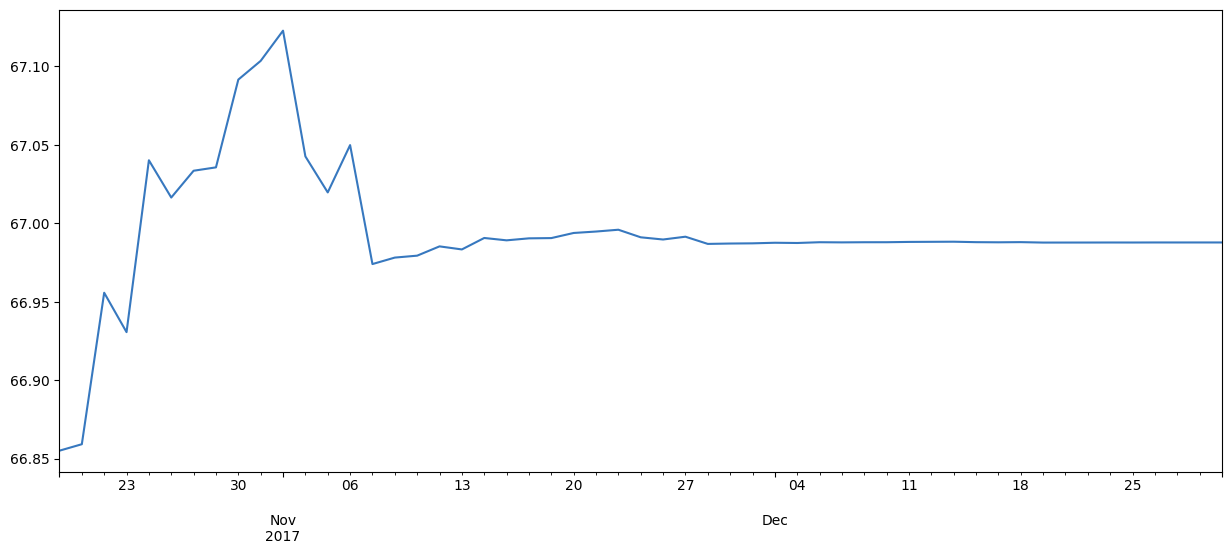

In [117]:
fcast10.plot()

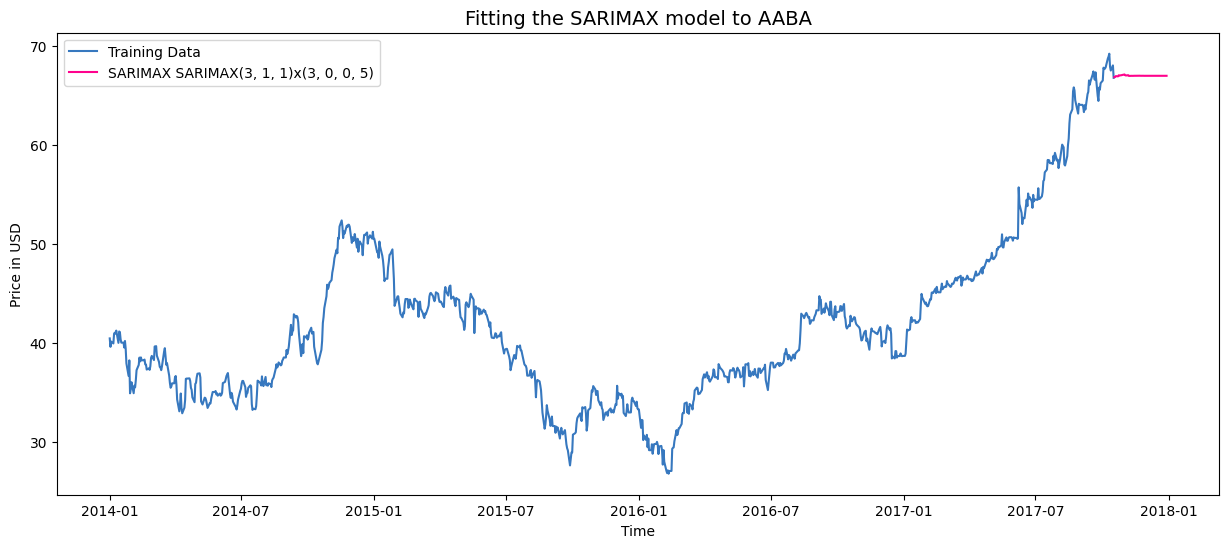

In [118]:
# Plotting the results
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Training Data')
plt.plot(fcast10.index, fcast10.values, label='SARIMAX SARIMAX(3, 1, 1)x(3, 0, 0, 5)', color=colors[2])

plt.legend(loc=2)
plt.title('Fitting the SARIMAX model to {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Price in USD', fontsize=10)

plt.show()

In [119]:
rmse = sqrt(mean_squared_error(df_test, fcast10.values))
me = (df_test.iloc[:,0] - fcast10.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast10.values)
stdres = residuen.std()
print('Forecast 10   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 10   -   RMSE: 3.5495, ME: 3.0808, StdRes: 1.7798


In [120]:
#Inserting accuracy measures
df_Error = pd.concat([df_Error, pd.DataFrame([{'Method': 'SARIMAX(3,1,1)x(3,0,0,5)', 'ME': me, 'RMSE': rmse, 'StdRes': stdres}])], ignore_index=True)

In [121]:
df_Error.sort_values('RMSE')

,Method,ME,RMSE,StdRes
6,Holt LT,1.129905,1.978303,1.783540
7,Holt ET,-1.062775,2.506362,2.291602
3,SimpleExpSmooth 0.25,2.368758,2.954997,1.783540
4,SimpleExpSmooth 0.5,2.684340,3.213515,1.783540
10,"SARIMAX(3,1,1)x(3,0,0,5)",3.080786,3.549540,1.779820
8,"Holt add, damped trend",3.269357,3.716139,1.783540
0,Naive Extension,3.294717,3.738470,1.783540
1,Naive Extension,3.294717,3.738470,1.783540
5,SimpleExpSmooth 1,3.294717,3.738470,1.783540
9,"ARIMA(0,1,0)",3.294717,3.738470,1.783540


In [122]:
fit8 = ExponentialSmoothing(df_ts_clean.iloc[:,0], seasonal_periods=5, trend='add', seasonal='mul', use_boxcox=True).fit()
fcast8 = fit8.forecast(15).rename("Holt-Winters Multiplicative")

In [123]:
fcast8

2018-01-01    69.672092
2018-01-02    69.592791
2018-01-03    69.936898
2018-01-04    69.801728
2018-01-05    69.833353
2018-01-08    69.655477
2018-01-09    69.576220
2018-01-10    69.920136
2018-01-11    69.785042
2018-01-12    69.816649
2018-01-15    69.638872
2018-01-16    69.559659
2018-01-17    69.903383
2018-01-18    69.768364
2018-01-19    69.799954
Freq: B, Name: Holt-Winters Multiplicative, dtype: float64

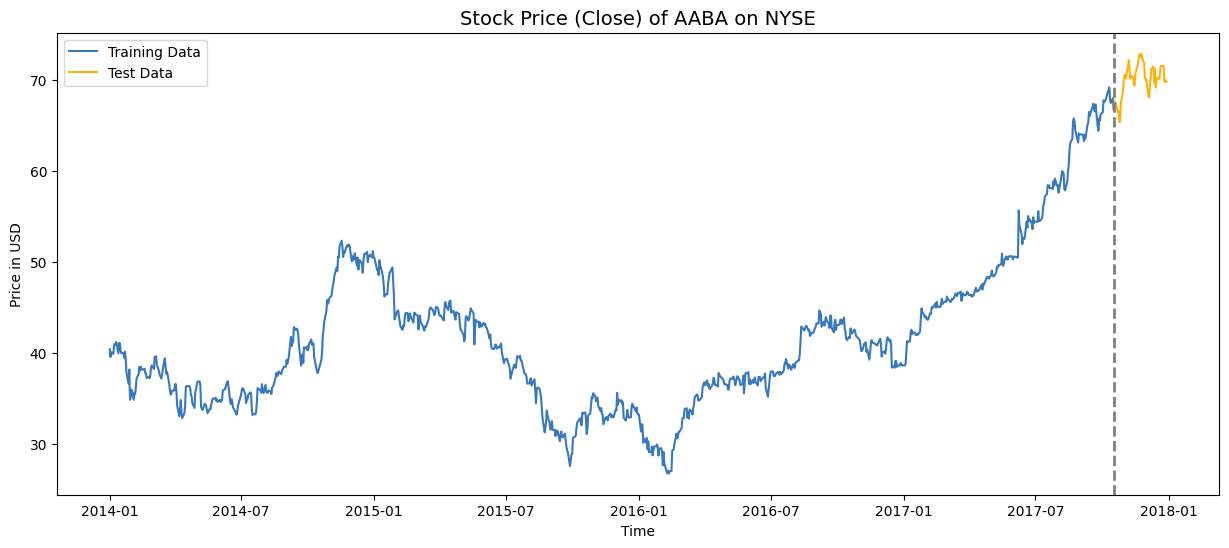

In [124]:
# Plot
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Training Data')
plt.plot(df_test.index, df_test.values, label='Test Data', color=colors[1])
plt.axvline(x = df_ts_clean.index[i_split], linewidth=2, color='grey', ls='--')
plt.legend(loc=2, fontsize=10)
plt.title('Stock Price (Close) of {} on NYSE'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Price in USD', fontsize=10)
plt.show()
